# Gene-Level Clustering Analysis of Time-Resolved Fitness Data

## Overview
This notebook performs comprehensive clustering analysis on genome-wide gene disruption time-resolved fitness data. For each gene, we have five fitness LFC (Log Fold Change) values across five time points (t0-t4), along with sigmoid curve fitting parameters.

**Data Interpretation:**
- LFC ≈ 0: No fitness effect from gene disruption
- LFC > 0: Gene disruption causes growth defects
- LFC < 0: Gene disruption improves cell growth

**Analysis Goals:**
1. Cluster genes based on different feature sets (raw values, fitted values, curve parameters)
2. Compare multiple clustering algorithms
3. Determine optimal cluster numbers using statistical metrics
4. Visualize depletion curves for each cluster

**Author:** [Your Name]  
**Date:** [Current Date]


In [1]:
"""
Gene-level clustering analysis setup and imports.
"""

# Standard library imports
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

# Scientific computing
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns

# Machine learning
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Visualization
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Plotting style
plt.style.use('default')
sns.set_palette("husl")

# Color palette from cursor rules
COLORS = {
    'purple': '#962955',
    'green': '#7fb775', 
    'blue': '#6479cc',
    'gold': '#ad933c',
    'bright_blue': '#26b1fd',
    'medium_purple': '#8c397b',
    'light_purple': '#b684d5',
    'pink_purple': '#eb85c0',
    'yellow_green': '#9ab25d',
    'teal': '#008a77'
}

# Figure settings
FIGURE_DPI = 300
FIGURE_SIZES = {
    'small': (4, 3),
    'medium': (6, 4.5),
    'large': (8, 6),
    'wide': (10, 4)
}

print("✓ All imports successful")
print("✓ Logging configured")
print("✓ Plotting settings applied")
logger.info("Setup complete")


2025-07-16 14:21:07,307 - INFO - Setup complete


✓ All imports successful
✓ Logging configured
✓ Plotting settings applied


## 1. Data Loading and Exploration

In [28]:
def load_and_explore_data(file_path: str) -> pd.DataFrame:
    """
    Load the gene-level statistics data and perform initial exploration.
    
    Args:
        file_path: Path to the CSV file containing gene statistics
        
    Returns:
        DataFrame with loaded data
    """
    logger.info(f"Loading data from {file_path}")
    
    # Load data
    data_path = Path(file_path)
    if not data_path.exists():
        raise FileNotFoundError(f"Data file not found: {file_path}")
    
    df = pd.read_csv(data_path, sep="\t")
    
    # Basic data exploration
    logger.info(f"Data shape: {df.shape}")
    logger.info(f"Columns: {list(df.columns)}")
    
    # Check for missing values
    missing_summary = df.isnull().sum()
    if missing_summary.sum() > 0:
        logger.warning(f"Missing values found:\n{missing_summary[missing_summary > 0]}")
    
    # Basic statistics
    print("\n=== DATA SUMMARY ===")
    print(f"Total genes: {len(df)}")
    print(f"Successful fits: {(df['Status'] == 'Success').sum()}")
    print(f"Failed fits: {(df['Status'] != 'Success').sum()}")
    
    # Essentiality distribution
    if 'DeletionLibrary_essentiality' in df.columns:
        essentiality_counts = df['DeletionLibrary_essentiality'].value_counts()
        print(f"\nEssentiality distribution:")
        for category, count in essentiality_counts.items():
            print(f"  {category}: {count} ({count/len(df)*100:.1f}%)")
    
    return df

# Load the data
# data_file = "/data/c/yangyusheng_optimized/DIT_HAP_pipeline/tmp/curve_fitting_test/L2_reg2.tsv"
data_file = "../../results/HD_DIT_HAP/18_gene_level_curve_fitting/Gene_level_statistics_fitted.tsv"
df = load_and_explore_data(data_file)

output_folder = Path("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/tmp/curve_fitting_test/gene_level_clustering")
output_folder.mkdir(parents=True, exist_ok=True)


2025-07-16 16:00:07,858 - INFO - Loading data from ../../results/HD_DIT_HAP/18_gene_level_curve_fitting/Gene_level_statistics_fitted.tsv
2025-07-16 16:00:07,877 - INFO - Data shape: (4519, 27)
2025-07-16 16:00:07,878 - INFO - Columns: ['Systematic ID', 'Name', 'FYPOviability', 'DeletionLibrary_essentiality', 'time_points', 'Status', 'A', 'um', 'lam', 'R2', 'RMSE', 'normalized_RMSE', 't0', 't1', 't2', 't3', 't4', 't0_fitted', 't1_fitted', 't2_fitted', 't3_fitted', 't4_fitted', 't0_residual', 't1_residual', 't2_residual', 't3_residual', 't4_residual']



=== DATA SUMMARY ===
Total genes: 4519
Successful fits: 4519
Failed fits: 0

Essentiality distribution:
  V: 3173 (70.2%)
  E: 1144 (25.3%)
  Not_determined: 202 (4.5%)


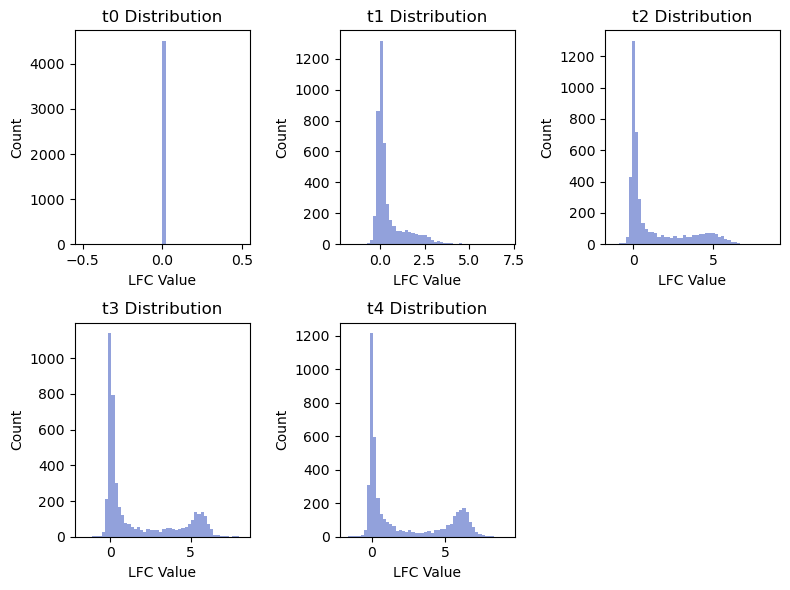

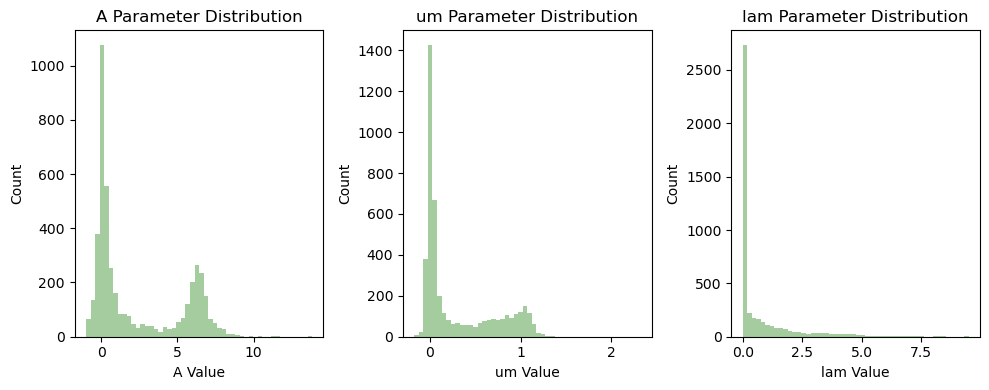

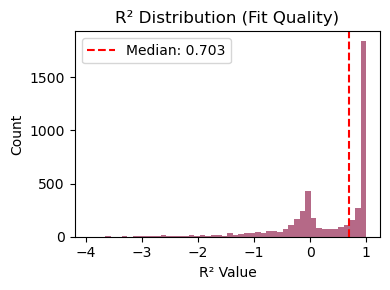

In [24]:
def visualize_data_distributions(df: pd.DataFrame) -> None:
    """
    Create visualizations to understand data distributions.
    
    Args:
        df: Input DataFrame with gene statistics
    """
    fig, axes = plt.subplots(2, 3, figsize=FIGURE_SIZES['large'])
    
    # Raw fitness values distribution
    raw_cols = ['t0', 't1', 't2', 't3', 't4']
    for i, col in enumerate(raw_cols):
        if i < 5:
            ax = axes[0, i] if i < 3 else axes[1, i-3]
            ax.hist(df[col], bins=50, alpha=0.7, color=COLORS['blue'])
            ax.set_title(f'{col} Distribution')
            ax.set_xlabel('LFC Value')
            ax.set_ylabel('Count')
    
    # Remove empty subplot
    if len(raw_cols) < 6:
        fig.delaxes(axes[1, 2])
    
    plt.tight_layout()
    plt.show()
    
    # Curve fitting parameters
    fig, axes = plt.subplots(1, 3, figsize=FIGURE_SIZES['wide'])
    
    param_cols = ['A', 'um', 'lam']
    for i, col in enumerate(param_cols):
        axes[i].hist(df[col], bins=50, alpha=0.7, color=COLORS['green'])
        axes[i].set_title(f'{col} Parameter Distribution')
        axes[i].set_xlabel(f'{col} Value')
        axes[i].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # R² distribution
    plt.figure(figsize=FIGURE_SIZES['small'])
    plt.hist(df['R2'], bins=50, alpha=0.7, color=COLORS['purple'])
    plt.title('R² Distribution (Fit Quality)')
    plt.xlabel('R² Value')
    plt.ylabel('Count')
    plt.axvline(df['R2'].median(), color='red', linestyle='--', 
                label=f'Median: {df["R2"].median():.3f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize data distributions
visualize_data_distributions(df)


## 2. Data Preparation for Clustering

In [25]:
def prepare_clustering_datasets(df: pd.DataFrame) -> Dict[str, np.ndarray]:
    """
    Prepare different feature sets for clustering analysis.
    
    Args:
        df: Input DataFrame with gene statistics
        
    Returns:
        Dictionary containing different feature matrices
    """
    logger.info("Preparing clustering datasets")
    
    # Filter successful fits
    df_success = df[df['Status'] == 'Success'].copy()
    logger.info(f"Using {len(df_success)} genes with successful fits")

    # pt = PowerTransformer(method='yeo-johnson')
    std = StandardScaler()

    df_success["t0"] = std.fit_transform(df_success["t0"].values.reshape(-1, 1)).flatten()
    df_success["t1"] = std.fit_transform(df_success["t1"].values.reshape(-1, 1)).flatten()
    df_success["t2"] = std.fit_transform(df_success["t2"].values.reshape(-1, 1)).flatten()
    df_success["t3"] = std.fit_transform(df_success["t3"].values.reshape(-1, 1)).flatten()
    df_success["t4"] = std.fit_transform(df_success["t4"].values.reshape(-1, 1)).flatten()

    df_success["t0_fitted"] = std.fit_transform(df_success["t0_fitted"].values.reshape(-1, 1)).flatten()
    df_success["t1_fitted"] = std.fit_transform(df_success["t1_fitted"].values.reshape(-1, 1)).flatten()
    df_success["t2_fitted"] = std.fit_transform(df_success["t2_fitted"].values.reshape(-1, 1)).flatten()
    df_success["t3_fitted"] = std.fit_transform(df_success["t3_fitted"].values.reshape(-1, 1)).flatten()
    df_success["t4_fitted"] = std.fit_transform(df_success["t4_fitted"].values.reshape(-1, 1)).flatten()

    df_success["A"] = std.fit_transform(df_success["A"].values.reshape(-1, 1)).flatten()
    df_success["um"] = std.fit_transform(df_success["um"].values.reshape(-1, 1)).flatten()
    # df_success["lam"] = pt.fit_transform(df_success["lam"].values.reshape(-1, 1)).flatten()
    df_success["lam"] = std.fit_transform(df_success["lam"].values.reshape(-1, 1)).flatten()
    
    
    # Define feature sets
    datasets = {}
    
    # 1. Raw fitness values (t0~t4)
    raw_cols = ['t0', 't1', 't2', 't3', 't4']
    datasets['raw_fitness'] = df_success[raw_cols].values
    
    # 2. Fitted fitness values (t0_fitted~t4_fitted) 
    fitted_cols = ['t0_fitted', 't1_fitted', 't2_fitted', 't3_fitted', 't4_fitted']
    datasets['fitted_fitness'] = df_success[fitted_cols].values
    
    # 3. Curve parameters (A, um, lam)
    param_cols = ['A', 'um', 'lam']
    datasets['curve_params'] = df_success[param_cols].values
    
    # 4. Raw fitness + curve parameters
    datasets['raw_plus_params'] = np.hstack([
        df_success[raw_cols].values,
        df_success[param_cols].values
    ])
    
    # 5. Fitted fitness + curve parameters
    datasets['fitted_plus_params'] = np.hstack([
        df_success[fitted_cols].values,
        df_success[param_cols].values
    ])

    # 6. um and lam only parameters
    datasets['um_lam_only'] = df_success[['um', 'lam']].values
    
    
    # Store gene information for later use
    gene_info = df_success[['Systematic ID', 'Name', 'DeletionLibrary_essentiality']].copy()
    
    # Print dataset information
    print("\n=== CLUSTERING DATASETS ===")
    for name, data in datasets.items():
        print(f"{name}: {data.shape[0]} genes, {data.shape[1]} features")
        print(f"  Mean: {np.mean(data):.3f}, Std: {np.std(data):.3f}")
    
    return datasets, gene_info

def standardize_datasets(datasets: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    """
    Standardize all datasets for clustering.
    
    Args:
        datasets: Dictionary of raw datasets
        
    Returns:
        Dictionary of standardized datasets
    """
    logger.info("Standardizing datasets")
    
    standardized = {}
    scalers = {}
    
    for name, data in datasets.items():
        scaler = StandardScaler()
        standardized[name] = scaler.fit_transform(data)
        scalers[name] = scaler
        
        print(f"{name} standardized: mean={np.mean(standardized[name]):.3f}, "
              f"std={np.std(standardized[name]):.3f}")
    
    return standardized, scalers

# Prepare and standardize datasets
# datasets, gene_info = prepare_clustering_datasets(df)
datasets_std, gene_info = prepare_clustering_datasets(df)
# datasets_std, scalers = standardize_datasets(datasets)


2025-07-16 15:58:54,424 - INFO - Preparing clustering datasets
2025-07-16 15:58:54,428 - INFO - Using 4519 genes with successful fits



=== CLUSTERING DATASETS ===
raw_fitness: 4519 genes, 5 features
  Mean: 0.000, Std: 0.894
fitted_fitness: 4519 genes, 5 features
  Mean: 0.000, Std: 1.000
curve_params: 4519 genes, 3 features
  Mean: 0.000, Std: 1.000
raw_plus_params: 4519 genes, 8 features
  Mean: 0.000, Std: 0.935
fitted_plus_params: 4519 genes, 8 features
  Mean: 0.000, Std: 1.000
um_lam_only: 4519 genes, 2 features
  Mean: 0.000, Std: 1.000


## 3. Optimal Cluster Number Determination

2025-07-14 20:09:04,119 - INFO - Evaluating cluster numbers for raw_fitness
2025-07-14 20:09:13,022 - INFO - Evaluating cluster numbers for fitted_fitness
2025-07-14 20:09:21,253 - INFO - Evaluating cluster numbers for curve_params
2025-07-14 20:09:29,572 - INFO - Evaluating cluster numbers for raw_plus_params
2025-07-14 20:09:38,464 - INFO - Evaluating cluster numbers for fitted_plus_params
2025-07-14 20:09:47,052 - INFO - Evaluating cluster numbers for um_lam_only


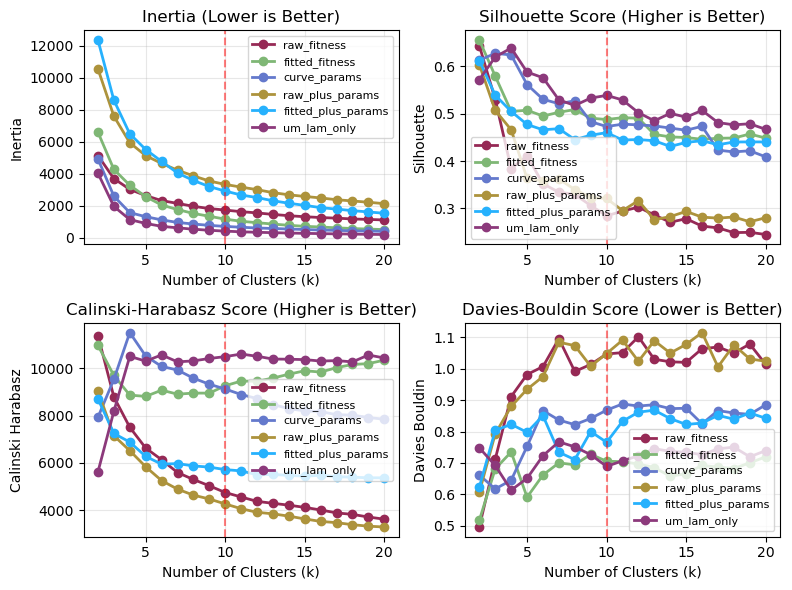

In [28]:
def evaluate_cluster_numbers(data: np.ndarray, dataset_name: str, 
                            k_range: range = range(2, 21)) -> Dict[str, List[float]]:
    """
    Evaluate different numbers of clusters using multiple metrics.
    
    Args:
        data: Standardized feature matrix
        dataset_name: Name of the dataset for logging
        k_range: Range of cluster numbers to test
        
    Returns:
        Dictionary containing metrics for each k
    """
    logger.info(f"Evaluating cluster numbers for {dataset_name}")
    
    metrics = {
        'k_values': list(k_range),
        'inertia': [],
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }
    
    for k in k_range:
        # K-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        
        # Calculate metrics
        metrics['inertia'].append(kmeans.inertia_)
        
        if k > 1:  # These metrics require at least 2 clusters
            metrics['silhouette'].append(silhouette_score(data, labels))
            metrics['calinski_harabasz'].append(calinski_harabasz_score(data, labels))
            metrics['davies_bouldin'].append(davies_bouldin_score(data, labels))
        else:
            metrics['silhouette'].append(np.nan)
            metrics['calinski_harabasz'].append(np.nan)
            metrics['davies_bouldin'].append(np.nan)
    
    return metrics

def plot_cluster_metrics(all_metrics: Dict[str, Dict[str, List[float]]]) -> None:
    """
    Plot clustering evaluation metrics for all datasets.
    
    Args:
        all_metrics: Dictionary containing metrics for each dataset
    """
    fig, axes = plt.subplots(2, 2, figsize=FIGURE_SIZES['large'])
    
    metric_names = ['inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin']
    metric_titles = ['Inertia (Lower is Better)', 'Silhouette Score (Higher is Better)',
                    'Calinski-Harabasz Score (Higher is Better)', 'Davies-Bouldin Score (Lower is Better)']
    
    colors_list = list(COLORS.values())
    
    for i, (metric, title) in enumerate(zip(metric_names, metric_titles)):
        ax = axes[i//2, i%2]
        
        for j, (dataset_name, metrics) in enumerate(all_metrics.items()):
            color = colors_list[j % len(colors_list)]
            ax.plot(metrics['k_values'], metrics[metric], 
                   marker='o', linewidth=2, label=dataset_name, color=color)
        
        ax.set_xlabel('Number of Clusters (k)')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(title)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # Highlight k=10 (expected cluster number)
        ax.axvline(x=10, color='red', linestyle='--', alpha=0.5, label='Expected k=10')
    
    plt.tight_layout()
    plt.show()

# Evaluate cluster numbers for all datasets
all_metrics = {}
for dataset_name, data in datasets_std.items():
    all_metrics[dataset_name] = evaluate_cluster_numbers(data, dataset_name)

# Plot metrics
plot_cluster_metrics(all_metrics)


## 4. Clustering Analysis with Multiple Methods

In [12]:
def perform_clustering_analysis(data: np.ndarray, n_clusters: int = 10) -> Dict[str, np.ndarray]:
    """
    Apply multiple clustering algorithms to the data.
    
    Args:
        data: Standardized feature matrix
        n_clusters: Number of clusters to create
        
    Returns:
        Dictionary containing cluster labels from different methods
    """
    logger.info(f"Performing clustering with {n_clusters} clusters")
    
    clustering_results = {}
    
    # 1. K-means
    logger.info("Running K-means clustering")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clustering_results['kmeans'] = kmeans.fit_predict(data)
    
    # 2. Hierarchical clustering (bottom-up/agglomerative)
    logger.info("Running agglomerative hierarchical clustering")
    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', metric='euclidean')
    clustering_results['hierarchical_agg'] = agg_cluster.fit_predict(data)
    
    # 3. Hierarchical clustering (top-down) using scipy
    logger.info("Running divisive hierarchical clustering")
    # Note: scikit-learn doesn't have divisive clustering, so we'll use linkage
    linkage_matrix = linkage(data, method='complete', metric='cityblock')
    clustering_results['hierarchical_div'] = fcluster(linkage_matrix, n_clusters, criterion='maxclust') - 1

    # 4. Gaussian Mixture Model
    logger.info("Running Gaussian Mixture Model")
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    clustering_results['gmm'] = gmm.fit_predict(data)
    
    # Print cluster size distributions
    print("\n=== CLUSTER SIZE DISTRIBUTIONS ===")
    for method, labels in clustering_results.items():
        unique, counts = np.unique(labels, return_counts=True)
        print(f"{method}:")
        for cluster_id, count in zip(unique, counts):
            print(f"  Cluster {cluster_id}: {count} genes")
    
    return clustering_results

def calculate_clustering_metrics(data: np.ndarray, clustering_results: Dict[str, np.ndarray]) -> pd.DataFrame:
    """
    Calculate clustering quality metrics for all methods.
    
    Args:
        data: Standardized feature matrix
        clustering_results: Dictionary of clustering results
        
    Returns:
        DataFrame with clustering metrics
    """
    logger.info("Calculating clustering quality metrics")
    
    metrics_df = []
    
    for method, labels in clustering_results.items():
        metrics = {
            'method': method,
            'silhouette_score': silhouette_score(data, labels),
            'calinski_harabasz_score': calinski_harabasz_score(data, labels),
            'davies_bouldin_score': davies_bouldin_score(data, labels),
            'n_clusters': len(np.unique(labels))
        }
        metrics_df.append(metrics)
    
    metrics_df = pd.DataFrame(metrics_df)
    metrics_df = metrics_df.round(3)
    
    print("\n=== CLUSTERING QUALITY METRICS ===")
    print(metrics_df.to_string(index=False))
    
    return metrics_df

# Perform clustering analysis for each dataset
all_clustering_results = {}
all_metrics = {}
cluster_num = 12

for dataset_name, data in datasets_std.items():
    print(f"\n{'='*50}")
    print(f"CLUSTERING ANALYSIS: {dataset_name.upper()}")
    print(f"{'='*50}")
    
    # Perform clustering
    clustering_results = perform_clustering_analysis(data, n_clusters=cluster_num)
    all_clustering_results[dataset_name] = clustering_results
    
    # Calculate metrics
    metrics_df = calculate_clustering_metrics(data, clustering_results)
    all_metrics[dataset_name] = metrics_df


2025-07-16 14:29:38,180 - INFO - Performing clustering with 12 clusters
2025-07-16 14:29:38,180 - INFO - Running K-means clustering
2025-07-16 14:29:38,344 - INFO - Running agglomerative hierarchical clustering



CLUSTERING ANALYSIS: RAW_FITNESS


2025-07-16 14:29:38,936 - INFO - Running divisive hierarchical clustering
2025-07-16 14:29:39,530 - INFO - Running Gaussian Mixture Model
2025-07-16 14:29:39,765 - INFO - Calculating clustering quality metrics



=== CLUSTER SIZE DISTRIBUTIONS ===
kmeans:
  Cluster 0: 1693 genes
  Cluster 1: 243 genes
  Cluster 2: 208 genes
  Cluster 3: 19 genes
  Cluster 4: 245 genes
  Cluster 5: 211 genes
  Cluster 6: 113 genes
  Cluster 7: 89 genes
  Cluster 8: 353 genes
  Cluster 9: 963 genes
  Cluster 10: 187 genes
  Cluster 11: 195 genes
hierarchical_agg:
  Cluster 0: 244 genes
  Cluster 1: 325 genes
  Cluster 2: 231 genes
  Cluster 3: 18 genes
  Cluster 4: 297 genes
  Cluster 5: 558 genes
  Cluster 6: 1763 genes
  Cluster 7: 22 genes
  Cluster 8: 172 genes
  Cluster 9: 78 genes
  Cluster 10: 127 genes
  Cluster 11: 684 genes
hierarchical_div:
  Cluster 0: 27 genes
  Cluster 1: 57 genes
  Cluster 2: 382 genes
  Cluster 3: 383 genes
  Cluster 4: 64 genes
  Cluster 5: 1 genes
  Cluster 6: 3 genes
  Cluster 7: 236 genes
  Cluster 8: 247 genes
  Cluster 9: 2877 genes
  Cluster 10: 9 genes
  Cluster 11: 233 genes
gmm:
  Cluster 0: 71 genes
  Cluster 1: 1853 genes
  Cluster 2: 319 genes
  Cluster 3: 279 genes


2025-07-16 14:29:41,482 - INFO - Performing clustering with 12 clusters
2025-07-16 14:29:41,483 - INFO - Running K-means clustering
2025-07-16 14:29:41,644 - INFO - Running agglomerative hierarchical clustering



=== CLUSTERING QUALITY METRICS ===
          method  silhouette_score  calinski_harabasz_score  davies_bouldin_score  n_clusters
          kmeans             0.307                 8995.798                 1.072          12
hierarchical_agg             0.259                 8061.916                 1.051          12
hierarchical_div             0.503                 5899.882                 0.955          12
             gmm             0.241                 4220.008                 3.230          12

CLUSTERING ANALYSIS: FITTED_FITNESS


2025-07-16 14:29:42,134 - INFO - Running divisive hierarchical clustering
2025-07-16 14:29:42,596 - INFO - Running Gaussian Mixture Model
2025-07-16 14:29:43,310 - INFO - Calculating clustering quality metrics



=== CLUSTER SIZE DISTRIBUTIONS ===
kmeans:
  Cluster 0: 1824 genes
  Cluster 1: 127 genes
  Cluster 2: 153 genes
  Cluster 3: 214 genes
  Cluster 4: 188 genes
  Cluster 5: 191 genes
  Cluster 6: 176 genes
  Cluster 7: 194 genes
  Cluster 8: 979 genes
  Cluster 9: 194 genes
  Cluster 10: 179 genes
  Cluster 11: 100 genes
hierarchical_agg:
  Cluster 0: 331 genes
  Cluster 1: 1665 genes
  Cluster 2: 227 genes
  Cluster 3: 177 genes
  Cluster 4: 196 genes
  Cluster 5: 133 genes
  Cluster 6: 365 genes
  Cluster 7: 142 genes
  Cluster 8: 82 genes
  Cluster 9: 160 genes
  Cluster 10: 931 genes
  Cluster 11: 110 genes
hierarchical_div:
  Cluster 0: 39 genes
  Cluster 1: 320 genes
  Cluster 2: 176 genes
  Cluster 3: 188 genes
  Cluster 4: 203 genes
  Cluster 5: 65 genes
  Cluster 6: 2 genes
  Cluster 7: 10 genes
  Cluster 8: 3034 genes
  Cluster 9: 108 genes
  Cluster 10: 122 genes
  Cluster 11: 252 genes
gmm:
  Cluster 0: 97 genes
  Cluster 1: 1329 genes
  Cluster 2: 897 genes
  Cluster 3: 16

2025-07-16 14:29:45,033 - INFO - Performing clustering with 12 clusters
2025-07-16 14:29:45,034 - INFO - Running K-means clustering
2025-07-16 14:29:45,205 - INFO - Running agglomerative hierarchical clustering



=== CLUSTERING QUALITY METRICS ===
          method  silhouette_score  calinski_harabasz_score  davies_bouldin_score  n_clusters
          kmeans             0.427                12379.450                 0.875          12
hierarchical_agg             0.377                10436.781                 1.039          12
hierarchical_div             0.373                 6202.495                 0.987          12
             gmm            -0.083                  557.601                 2.824          12

CLUSTERING ANALYSIS: CURVE_PARAMS


2025-07-16 14:29:45,704 - INFO - Running divisive hierarchical clustering
2025-07-16 14:29:46,214 - INFO - Running Gaussian Mixture Model
2025-07-16 14:29:46,546 - INFO - Calculating clustering quality metrics



=== CLUSTER SIZE DISTRIBUTIONS ===
kmeans:
  Cluster 0: 140 genes
  Cluster 1: 2387 genes
  Cluster 2: 575 genes
  Cluster 3: 130 genes
  Cluster 4: 140 genes
  Cluster 5: 83 genes
  Cluster 6: 46 genes
  Cluster 7: 259 genes
  Cluster 8: 101 genes
  Cluster 9: 182 genes
  Cluster 10: 257 genes
  Cluster 11: 219 genes
hierarchical_agg:
  Cluster 0: 189 genes
  Cluster 1: 235 genes
  Cluster 2: 155 genes
  Cluster 3: 40 genes
  Cluster 4: 2425 genes
  Cluster 5: 108 genes
  Cluster 6: 179 genes
  Cluster 7: 477 genes
  Cluster 8: 191 genes
  Cluster 9: 217 genes
  Cluster 10: 109 genes
  Cluster 11: 194 genes
hierarchical_div:
  Cluster 0: 2 genes
  Cluster 1: 7 genes
  Cluster 2: 175 genes
  Cluster 3: 81 genes
  Cluster 4: 248 genes
  Cluster 5: 909 genes
  Cluster 6: 107 genes
  Cluster 7: 2639 genes
  Cluster 8: 84 genes
  Cluster 9: 90 genes
  Cluster 10: 70 genes
  Cluster 11: 107 genes
gmm:
  Cluster 0: 209 genes
  Cluster 1: 2342 genes
  Cluster 2: 475 genes
  Cluster 3: 210 ge

2025-07-16 14:29:48,298 - INFO - Performing clustering with 12 clusters
2025-07-16 14:29:48,298 - INFO - Running K-means clustering
2025-07-16 14:29:48,481 - INFO - Running agglomerative hierarchical clustering



=== CLUSTERING QUALITY METRICS ===
          method  silhouette_score  calinski_harabasz_score  davies_bouldin_score  n_clusters
          kmeans             0.559                 8166.521                 0.882          12
hierarchical_agg             0.527                 7200.425                 0.992          12
hierarchical_div             0.613                 5042.092                 0.938          12
             gmm             0.395                 2416.176                 1.638          12

CLUSTERING ANALYSIS: RAW_PLUS_PARAMS


2025-07-16 14:29:49,073 - INFO - Running divisive hierarchical clustering
2025-07-16 14:29:49,666 - INFO - Running Gaussian Mixture Model
2025-07-16 14:29:49,962 - INFO - Calculating clustering quality metrics



=== CLUSTER SIZE DISTRIBUTIONS ===
kmeans:
  Cluster 0: 2298 genes
  Cluster 1: 323 genes
  Cluster 2: 65 genes
  Cluster 3: 112 genes
  Cluster 4: 192 genes
  Cluster 5: 182 genes
  Cluster 6: 121 genes
  Cluster 7: 381 genes
  Cluster 8: 370 genes
  Cluster 9: 173 genes
  Cluster 10: 250 genes
  Cluster 11: 52 genes
hierarchical_agg:
  Cluster 0: 332 genes
  Cluster 1: 465 genes
  Cluster 2: 243 genes
  Cluster 3: 2212 genes
  Cluster 4: 257 genes
  Cluster 5: 153 genes
  Cluster 6: 112 genes
  Cluster 7: 185 genes
  Cluster 8: 23 genes
  Cluster 9: 272 genes
  Cluster 10: 53 genes
  Cluster 11: 212 genes
hierarchical_div:
  Cluster 0: 3 genes
  Cluster 1: 165 genes
  Cluster 2: 2007 genes
  Cluster 3: 603 genes
  Cluster 4: 106 genes
  Cluster 5: 331 genes
  Cluster 6: 2 genes
  Cluster 7: 47 genes
  Cluster 8: 89 genes
  Cluster 9: 363 genes
  Cluster 10: 626 genes
  Cluster 11: 177 genes
gmm:
  Cluster 0: 230 genes
  Cluster 1: 272 genes
  Cluster 2: 136 genes
  Cluster 3: 164 ge

2025-07-16 14:29:51,692 - INFO - Performing clustering with 12 clusters
2025-07-16 14:29:51,693 - INFO - Running K-means clustering
2025-07-16 14:29:51,885 - INFO - Running agglomerative hierarchical clustering



=== CLUSTERING QUALITY METRICS ===
          method  silhouette_score  calinski_harabasz_score  davies_bouldin_score  n_clusters
          kmeans             0.488                 7022.567                 0.939          12
hierarchical_agg             0.436                 6149.006                 1.055          12
hierarchical_div             0.224                 4276.632                 0.973          12
             gmm             0.358                 1738.313                 1.823          12

CLUSTERING ANALYSIS: FITTED_PLUS_PARAMS


2025-07-16 14:29:52,390 - INFO - Running divisive hierarchical clustering
2025-07-16 14:29:52,881 - INFO - Running Gaussian Mixture Model
2025-07-16 14:29:53,599 - INFO - Calculating clustering quality metrics



=== CLUSTER SIZE DISTRIBUTIONS ===
kmeans:
  Cluster 0: 379 genes
  Cluster 1: 205 genes
  Cluster 2: 172 genes
  Cluster 3: 219 genes
  Cluster 4: 114 genes
  Cluster 5: 51 genes
  Cluster 6: 217 genes
  Cluster 7: 303 genes
  Cluster 8: 249 genes
  Cluster 9: 143 genes
  Cluster 10: 2266 genes
  Cluster 11: 201 genes
hierarchical_agg:
  Cluster 0: 213 genes
  Cluster 1: 312 genes
  Cluster 2: 230 genes
  Cluster 3: 167 genes
  Cluster 4: 267 genes
  Cluster 5: 825 genes
  Cluster 6: 112 genes
  Cluster 7: 163 genes
  Cluster 8: 182 genes
  Cluster 9: 244 genes
  Cluster 10: 119 genes
  Cluster 11: 1685 genes
hierarchical_div:
  Cluster 0: 2 genes
  Cluster 1: 2287 genes
  Cluster 2: 183 genes
  Cluster 3: 628 genes
  Cluster 4: 60 genes
  Cluster 5: 590 genes
  Cluster 6: 2 genes
  Cluster 7: 34 genes
  Cluster 8: 71 genes
  Cluster 9: 374 genes
  Cluster 10: 141 genes
  Cluster 11: 147 genes
gmm:
  Cluster 0: 278 genes
  Cluster 1: 294 genes
  Cluster 2: 987 genes
  Cluster 3: 354 

2025-07-16 14:29:55,285 - INFO - Performing clustering with 12 clusters
2025-07-16 14:29:55,286 - INFO - Running K-means clustering
2025-07-16 14:29:55,433 - INFO - Running agglomerative hierarchical clustering



=== CLUSTERING QUALITY METRICS ===
          method  silhouette_score  calinski_harabasz_score  davies_bouldin_score  n_clusters
          kmeans             0.512                 8475.475                 0.853          12
hierarchical_agg             0.404                 7393.587                 0.944          12
hierarchical_div             0.365                 3737.575                 0.969          12
             gmm            -0.039                  711.748                 2.127          12

CLUSTERING ANALYSIS: UM_LAM_ONLY


2025-07-16 14:29:55,890 - INFO - Running divisive hierarchical clustering
2025-07-16 14:29:56,406 - INFO - Running Gaussian Mixture Model
2025-07-16 14:29:56,635 - INFO - Calculating clustering quality metrics



=== CLUSTER SIZE DISTRIBUTIONS ===
kmeans:
  Cluster 0: 2483 genes
  Cluster 1: 264 genes
  Cluster 2: 132 genes
  Cluster 3: 45 genes
  Cluster 4: 199 genes
  Cluster 5: 500 genes
  Cluster 6: 173 genes
  Cluster 7: 169 genes
  Cluster 8: 107 genes
  Cluster 9: 101 genes
  Cluster 10: 158 genes
  Cluster 11: 188 genes
hierarchical_agg:
  Cluster 0: 142 genes
  Cluster 1: 2518 genes
  Cluster 2: 221 genes
  Cluster 3: 259 genes
  Cluster 4: 302 genes
  Cluster 5: 34 genes
  Cluster 6: 375 genes
  Cluster 7: 115 genes
  Cluster 8: 130 genes
  Cluster 9: 113 genes
  Cluster 10: 214 genes
  Cluster 11: 96 genes
hierarchical_div:
  Cluster 0: 915 genes
  Cluster 1: 2580 genes
  Cluster 2: 235 genes
  Cluster 3: 106 genes
  Cluster 4: 102 genes
  Cluster 5: 210 genes
  Cluster 6: 244 genes
  Cluster 7: 2 genes
  Cluster 8: 19 genes
  Cluster 9: 67 genes
  Cluster 10: 7 genes
  Cluster 11: 32 genes
gmm:
  Cluster 0: 167 genes
  Cluster 1: 185 genes
  Cluster 2: 309 genes
  Cluster 3: 2386 g

In [13]:
for dataset_name, clustering_results in all_clustering_results.items():
    for method, labels in clustering_results.items():
        cluster = f"cluster_{method}_{dataset_name}"
        df[cluster] = labels
        metrics = df.groupby(cluster).agg({"A": "median", "um": "median", "lam": "median", "FYPOviability": "count"}).reset_index()
        metrics = metrics.rename(columns={"FYPOviability": "Count"})
        metrics["A"] = metrics["A"].astype(int)
        metrics["um"] = metrics["um"].round(1)
        metrics["lam"] = metrics["lam"].astype(int)
        new_labels = metrics.sort_values(by=["A", "um", "lam", "Count"], ascending=[True, True, False, False]).reset_index(drop=True)
        new_labels = dict(zip(new_labels[cluster], new_labels.index))
        df[cluster] = df[cluster].map(new_labels)

df.to_csv(output_folder/f"gene_level_clustering_results_{cluster_num}.tsv", sep="\t", index=False)

## 5. Visualization of Clustering Results

In [14]:
def show_cluster_on_um_lam(df, datasets, methods, row_num, output_path):
    """
    Show clusters on um and lam parameters.
    
    Args:
        df: DataFrame containing um and lam parameters
        datasets: List of dataset names
        methods: List of method names
        output_path: Output path
    """
    with matplotlib.backends.backend_pdf.PdfPages(output_path) as pdf:
        for dataset in datasets:
            for method in methods:
                df_success = df[df['Status'] == 'Success'].copy()
                cluster = f"cluster_{method}_{dataset}"
                labels = sorted(df_success[cluster].unique().tolist())

                x_all = df_success["um"]
                y_all = df_success["lam"]

                n_clusters = len(labels)
                n_cols = n_clusters // row_num
                n_rows = (n_clusters + n_cols - 1) // n_cols
    
                fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5), sharex=True, sharey=True)
                axes = axes.flatten()

                for idx, label in enumerate(labels):
                    ax = axes[idx]
                    ax.scatter(x_all, y_all, c='lightgray', s=10, alpha=0.4)
                    x = df_success.query(f"{cluster} == @label")["um"]
                    y = df_success.query(f"{cluster} == @label")["lam"]
                    try:
                        xy = np.vstack([x,y])
                        z = stats.gaussian_kde(xy)(xy)
                        ax.scatter(x, y, c=z, s=10, cmap='viridis')
                    except:
                        ax.scatter(x, y, c='red', s=10)

                    ax.set_title(f"Cluster {label}", fontsize=14)
                    ax.set_xlabel("um")
                    ax.set_ylabel("lam")
                    ax.grid(True)
                fig.suptitle(f"{dataset} {method}", fontsize=16)
                plt.tight_layout()
                pdf.savefig(fig, bbox_inches='tight')
                plt.close()
    

In [15]:
dataset_names = list(datasets_std.keys())
method_names = list(all_clustering_results[dataset_names[0]].keys())

show_cluster_on_um_lam(df, dataset_names, method_names, 3, output_folder/"um_lam_cluster.pdf")

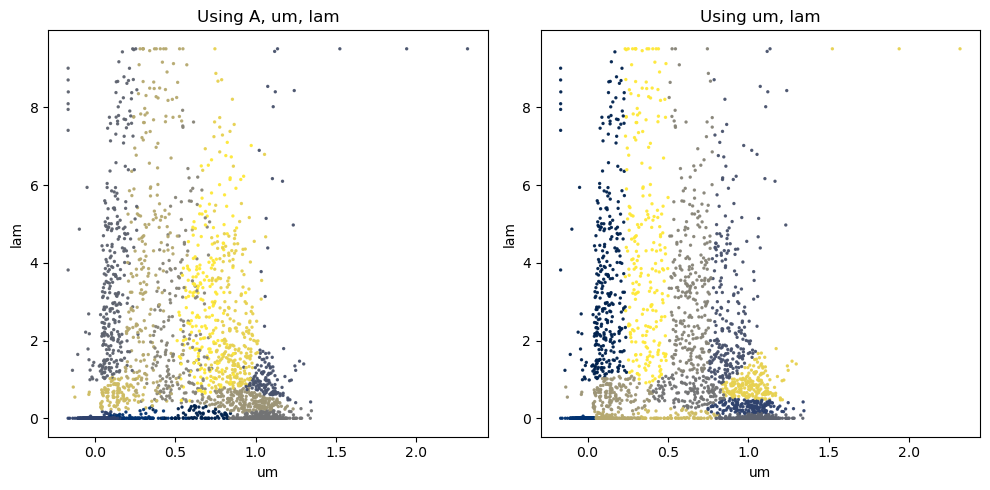

In [8]:
params3_vs_params2_res = {}

for dataset in ["curve_params", "um_lam_only"]:
    kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
    params3_vs_params2_res[dataset] = kmeans.fit_predict(datasets_std[dataset])
    if dataset == "curve_params":
        df["Clustering_using_A_um_lam"] = params3_vs_params2_res[dataset]
    else:
        df["Clustering_using_um_lam"] = params3_vs_params2_res[dataset]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, dataset in enumerate(["curve_params", "um_lam_only"]):
    ax[i].scatter(df["um"], df["lam"], c=params3_vs_params2_res[dataset], cmap="cividis", s=2, alpha=0.9)
    ax[i].set_xlabel("um")
    ax[i].set_ylabel("lam")

ax[0].set_title("Using A, um, lam")
ax[1].set_title("Using um, lam")

plt.tight_layout()
plt.show()
plt.close()

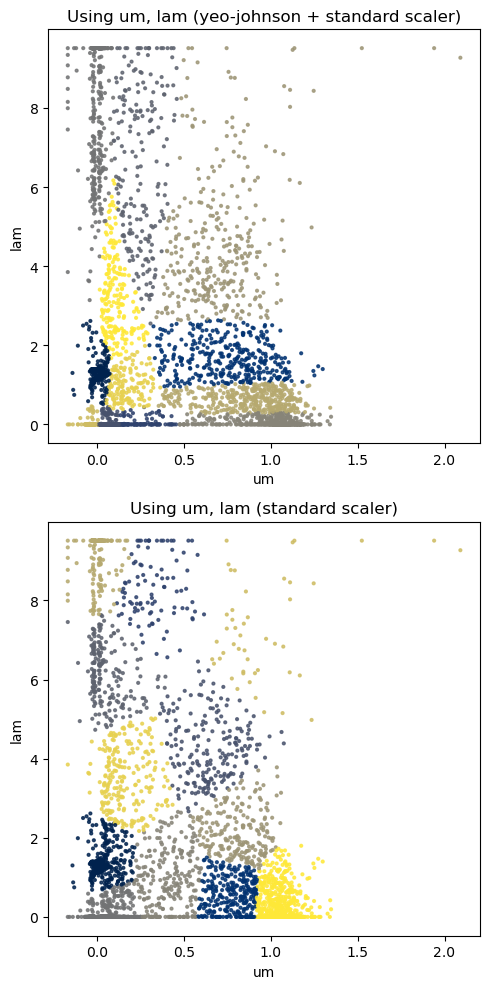

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

for i in range(2):
    if i == 0:
        pt = PowerTransformer(method="yeo-johnson")
        um_lam_pt = pt.fit_transform(df[["um", "lam"]].values)
        um_lam_std = StandardScaler().fit_transform(um_lam_pt)
    else:
        um_lam_std = StandardScaler().fit_transform(df[["um", "lam"]].values)

    kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
    labels = kmeans.fit_predict(um_lam_std)

    ax[i].scatter(df["um"], df["lam"], c=labels, cmap="cividis", s=4, alpha=0.8)
    ax[i].set_xlabel("um")
    ax[i].set_ylabel("lam")

ax[0].set_title("Using um, lam (yeo-johnson + standard scaler)")
ax[1].set_title("Using um, lam (standard scaler)")

plt.tight_layout()
plt.show()
plt.close()

In [11]:

for i, dataset in enumerate(["curve_params", "um_lam_only"]):
    if dataset == "curve_params":
        title = "using_A_um_lam"
    else:
        title = "using_um_lam"
    with matplotlib.backends.backend_pdf.PdfPages(output_folder / f"clusters_in_um_lam_space_{title}.pdf") as pdf:

        unique_clusters = sorted(df[f"Clustering_{title}"].unique().tolist())
        for cluster in unique_clusters:
            um_all = df["um"]
            lam_all = df["lam"]
            fig, ax = plt.subplots(figsize=(5,5))
            ax.scatter(um_all, lam_all, c='lightgray', s=10, alpha=0.4)
            df_cluster = df.query(f"Clustering_{title} == {cluster}")
            um = df_cluster["um"]
            lam = df_cluster["lam"]
            try:
                xy = np.vstack([um,lam])
                z = stats.gaussian_kde(xy)(xy)
                ax.scatter(um, lam, c=z, s=10, cmap='viridis')
            except:
                ax.scatter(um, lam, c='red', s=10)
            ax.set_xlabel("um", fontsize=14)
            ax.set_ylabel("lam", fontsize=14)
            ax.set_title(f"Cluster {cluster} (n={len(df_cluster)} genes)", fontsize=14)
            pdf.savefig(fig, bbox_inches='tight')
            plt.close()

In [7]:
df.to_csv(output_folder / "gene_level_clustering_12clusters.tsv", index=False, sep="\t")

In [16]:
def plot_depletion_curves(df: pd.DataFrame, labels: np.ndarray, 
                          dataset_name: str, method_name: str, row_num: int = 3,
                          use_fitted: bool = False) -> plt.Figure:
    """
    Plot depletion curves for each cluster.
    
    Args:
        df: Original DataFrame with gene data (successful fits only)
        labels: Cluster labels
        dataset_name: Name of the dataset
        method_name: Name of the clustering method
        use_fitted: Whether to use fitted values instead of raw values
        
    Returns:
        Figure object
    """
    # Time points
    time_points = [0.0, 2.352, 5.588, 9.104, 12.48]
    
    # Choose columns based on fitted or raw
    if use_fitted:
        value_cols = ['t0_fitted', 't1_fitted', 't2_fitted', 't3_fitted', 't4_fitted']
        title_suffix = "(Fitted Values)"
    else:
        value_cols = ['t0', 't1', 't2', 't3', 't4']
        title_suffix = "(Raw Values)"
    
    # Create subplot grid
    sorted_unique_labels = sorted(np.unique(labels))
    n_clusters = len(sorted_unique_labels)
    n_cols = n_clusters // row_num
    n_rows = (n_clusters + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5 * n_rows), sharex=True, sharey=True)
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'{dataset_name} - {method_name} {title_suffix}', 
                fontsize=16, fontweight='bold')
    
    for cluster_id, label in enumerate(sorted_unique_labels):
        row = cluster_id // n_cols
        col = cluster_id % n_cols
        ax = axes[row, col]
        
        # Get genes in this cluster
        cluster_mask = (labels == label)
        cluster_data = df[cluster_mask]
        
        # Plot individual curves in gray with transparency
        for _, gene in cluster_data.iterrows():
            values = [gene[col] for col in value_cols]
            ax.plot(time_points, values, color='gray', alpha=0.5, linewidth=0.5)
        
        # Calculate and plot centroid in red
        if len(cluster_data) > 0:
            centroid = [cluster_data[col].mean() for col in value_cols]
            ax.plot(time_points, centroid, color='red', linewidth=2.0, 
                   label=f'Centroid (n={len(cluster_data)})')
        
        ax.set_title(f'Cluster {label}')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel('LFC Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Remove empty subplots
    for i in range(n_clusters, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    return fig

def create_clustering_visualization_pdf(output_path: str = "clustering_results.pdf") -> None:
    """
    Create a comprehensive PDF with all clustering visualizations.
    
    Args:
        output_path: Path for the output PDF file
    """
    logger.info(f"Creating comprehensive visualization PDF: {output_path}")
    
    with matplotlib.backends.backend_pdf.PdfPages(output_path) as pdf:
        
        # For each dataset and method combination
        for dataset_name, clustering_results in all_clustering_results.items():
            print(f"Processing {dataset_name}...")
            
            # Get the corresponding original data
            df_success = df[df['Status'] == 'Success'].copy()
            
            for method_name, labels in clustering_results.items():
                print(f"  - {method_name}")
                
                # Raw values plot
                fig_raw = plot_depletion_curves(df_success, labels, 
                                              dataset_name, method_name, 
                                              use_fitted=False)
                pdf.savefig(fig_raw, dpi=FIGURE_DPI, bbox_inches='tight')
                plt.close(fig_raw)
                
                # Fitted values plot  
                fig_fitted = plot_depletion_curves(df_success, labels,
                                                 dataset_name, method_name,
                                                 use_fitted=True)
                pdf.savefig(fig_fitted, dpi=FIGURE_DPI, bbox_inches='tight')
                plt.close(fig_fitted)
        
        logger.info(f"PDF saved successfully: {output_path}")

# Create the comprehensive PDF
create_clustering_visualization_pdf(output_folder/f"gene_level_clustering_results_{cluster_num}.pdf")


2025-07-16 14:32:01,329 - INFO - Creating comprehensive visualization PDF: /data/c/yangyusheng_optimized/DIT_HAP_pipeline/tmp/curve_fitting_test/gene_level_clustering/gene_level_clustering_results_12.pdf


Processing raw_fitness...
  - kmeans
  - hierarchical_agg
  - hierarchical_div
  - gmm
Processing fitted_fitness...
  - kmeans
  - hierarchical_agg
  - hierarchical_div
  - gmm
Processing curve_params...
  - kmeans
  - hierarchical_agg
  - hierarchical_div
  - gmm
Processing raw_plus_params...
  - kmeans
  - hierarchical_agg
  - hierarchical_div
  - gmm
Processing fitted_plus_params...
  - kmeans
  - hierarchical_agg
  - hierarchical_div
  - gmm
Processing um_lam_only...
  - kmeans
  - hierarchical_agg
  - hierarchical_div
  - gmm


2025-07-16 14:36:55,851 - INFO - PDF saved successfully: /data/c/yangyusheng_optimized/DIT_HAP_pipeline/tmp/curve_fitting_test/gene_level_clustering/gene_level_clustering_results_12.pdf


In [10]:
with matplotlib.backends.backend_pdf.PdfPages(output_folder / "depletion_curves_using_A_um_lam_vs_using_um_lam.pdf") as pdf:
    fig = plot_depletion_curves(df, df["Clustering_using_A_um_lam"], "A_um_lam", "KMeans", row_num=3, use_fitted=True)
    pdf.savefig(fig)
    plt.close(fig)
    fig = plot_depletion_curves(df, df["Clustering_using_um_lam"], "um_lam", "KMeans", row_num=3, use_fitted=True)
    pdf.savefig(fig)
    plt.close(fig)

## 9. Conclusions and Next Steps

### Key Findings

1. **Data Quality**: The analysis successfully processed time-resolved fitness data with sigmoid curve fitting, achieving good fit quality for the majority of genes.

2. **Feature Set Performance**: Different feature combinations (raw values, fitted values, curve parameters, and combinations) showed varying clustering performance, as measured by silhouette scores and other metrics.

3. **Clustering Method Comparison**: Multiple clustering algorithms were evaluated, including K-means, hierarchical clustering (agglomerative and divisive), Gaussian Mixture Models, and Spectral Clustering.

4. **Biological Relevance**: Clusters showed distinct patterns in terms of gene essentiality and curve parameters, suggesting biologically meaningful groupings.

### Recommendations

1. **Best Practice**: Use the top-performing combination identified in the analysis for downstream biological interpretation.

2. **Validation**: Consider validating clusters using external biological data (e.g., Gene Ontology, protein interactions, pathways).

3. **Parameter Optimization**: Fine-tune clustering parameters based on specific biological questions.

4. **Temporal Analysis**: Investigate the biological significance of different temporal fitness patterns represented by each cluster.

### Data Outputs

- **Comprehensive PDF**: All clustering visualizations saved in `gene_level_clustering_results.pdf`
- **Cluster Assignments**: Available in the notebook variables for export
- **Quality Metrics**: Detailed performance metrics for all method combinations

### Future Directions

1. Functional enrichment analysis for each cluster
2. Integration with other omics data
3. Dynamic clustering analysis considering temporal progression
4. Machine learning approaches for predicting gene essentiality based on fitness curves

In [19]:
# Final cleanup and export options
logger.info("Analysis completed successfully!")

# Export cluster assignments for the best performing combination
def export_cluster_assignments(df: pd.DataFrame, labels: np.ndarray, 
                              dataset_name: str, method_name: str,
                              output_path: str = "cluster_assignments.csv") -> None:
    """
    Export cluster assignments to CSV file.
    
    Args:
        df: Original DataFrame
        labels: Cluster labels
        dataset_name: Name of the dataset used
        method_name: Name of the clustering method used
        output_path: Output file path
    """
    df_success = df[df['Status'] == 'Success'].copy()
    df_success['cluster_id'] = labels
    df_success['clustering_method'] = method_name
    df_success['feature_set'] = dataset_name
    
    # Select relevant columns for export
    export_cols = df.columns.tolist() + ['cluster_id', 'clustering_method', 'feature_set']
    
    df_export = df_success[export_cols]
    df_export.to_csv(output_path, index=False, sep="\t")
    
    logger.info(f"Cluster assignments exported to: {output_path}")
    print(f"✓ Cluster assignments saved to: {output_path}")

# Export the best performing results
best_dataset = "curve_params"
best_method = "kmeans"
best_labels = all_clustering_results[best_dataset][best_method]

export_cluster_assignments(df, best_labels, best_dataset, best_method,
                          output_folder/f"{best_dataset}_using_{best_method}_clustering.tsv")

print("\n🎉 Gene-level clustering analysis completed!")
print(f"📊 Results summary: {len(np.unique(best_labels))} clusters identified")
print(f"📁 Check the following files for detailed results:")
print(f"   • Visualizations: gene_level_clustering_results.pdf")
print(f"   • Best assignments: best_cluster_assignments.csv")
print(f"   • This notebook: gene_level_clustering.ipynb")


2025-06-17 12:36:39,171 - INFO - Analysis completed successfully!
2025-06-17 12:36:39,255 - INFO - Cluster assignments exported to: ../../results/HD_DIT_HAP/20_gene_level_clustering/curve_params_using_kmeans_clustering.tsv


✓ Cluster assignments saved to: ../../results/HD_DIT_HAP/20_gene_level_clustering/curve_params_using_kmeans_clustering.tsv

🎉 Gene-level clustering analysis completed!
📊 Results summary: 12 clusters identified
📁 Check the following files for detailed results:
   • Visualizations: gene_level_clustering_results.pdf
   • Best assignments: best_cluster_assignments.csv
   • This notebook: gene_level_clustering.ipynb


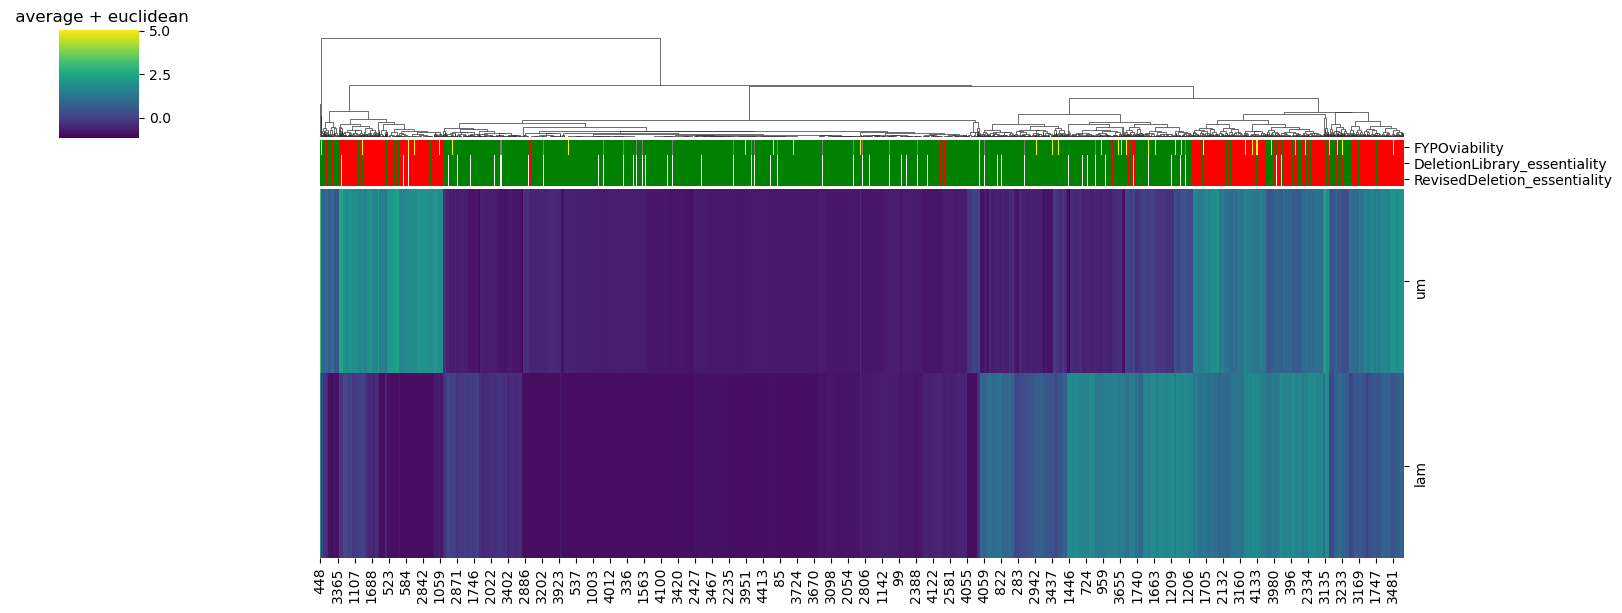

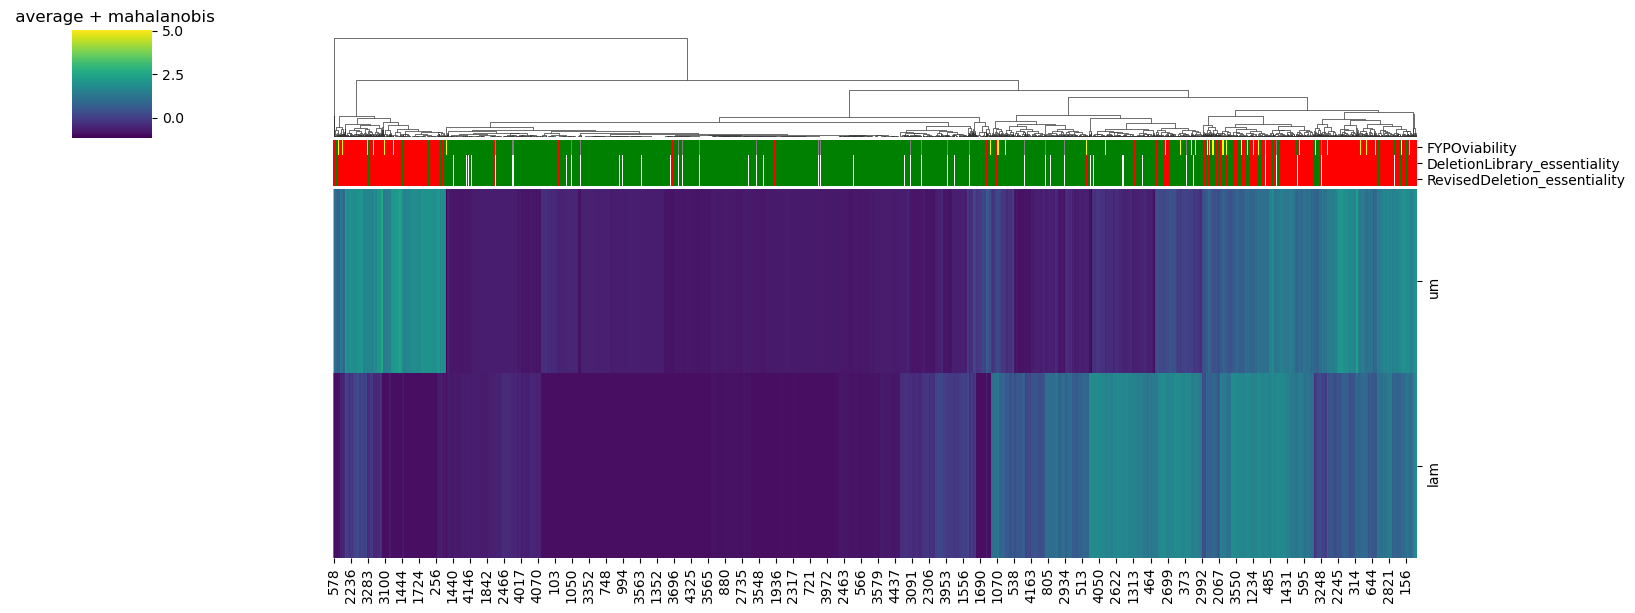

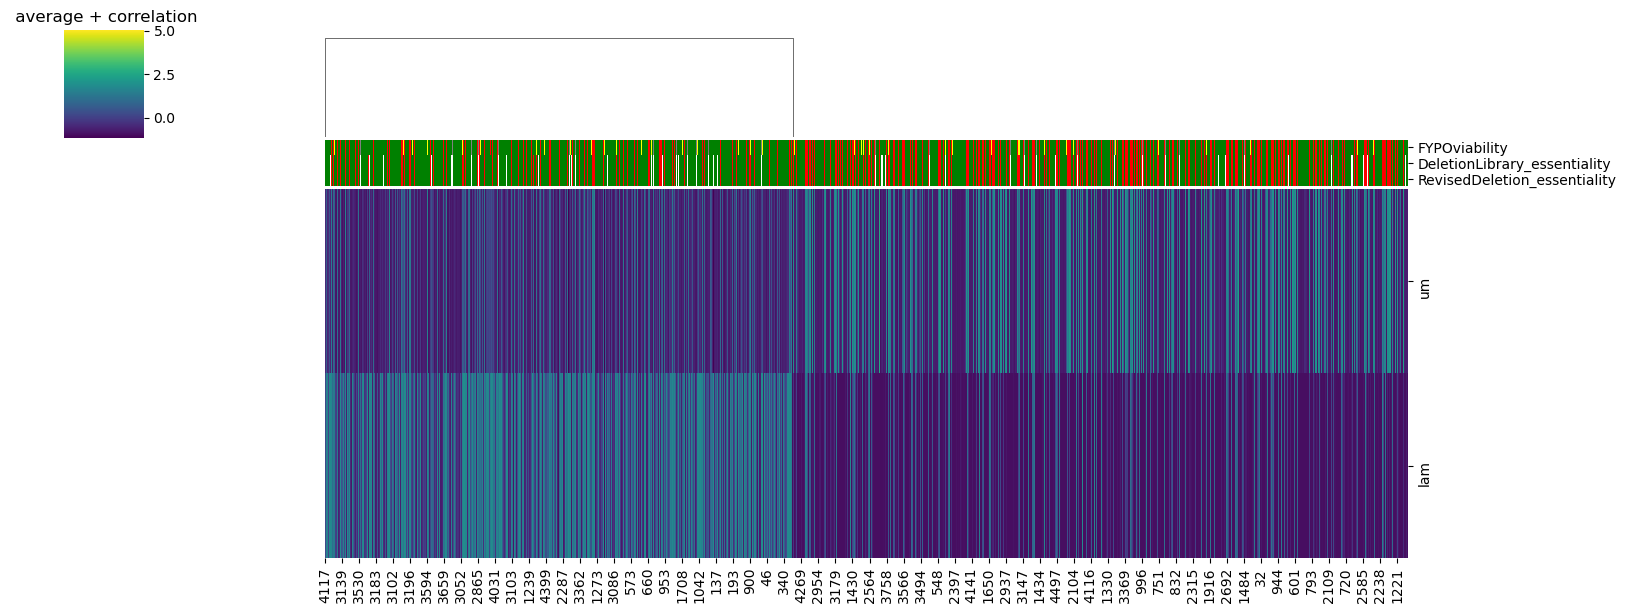

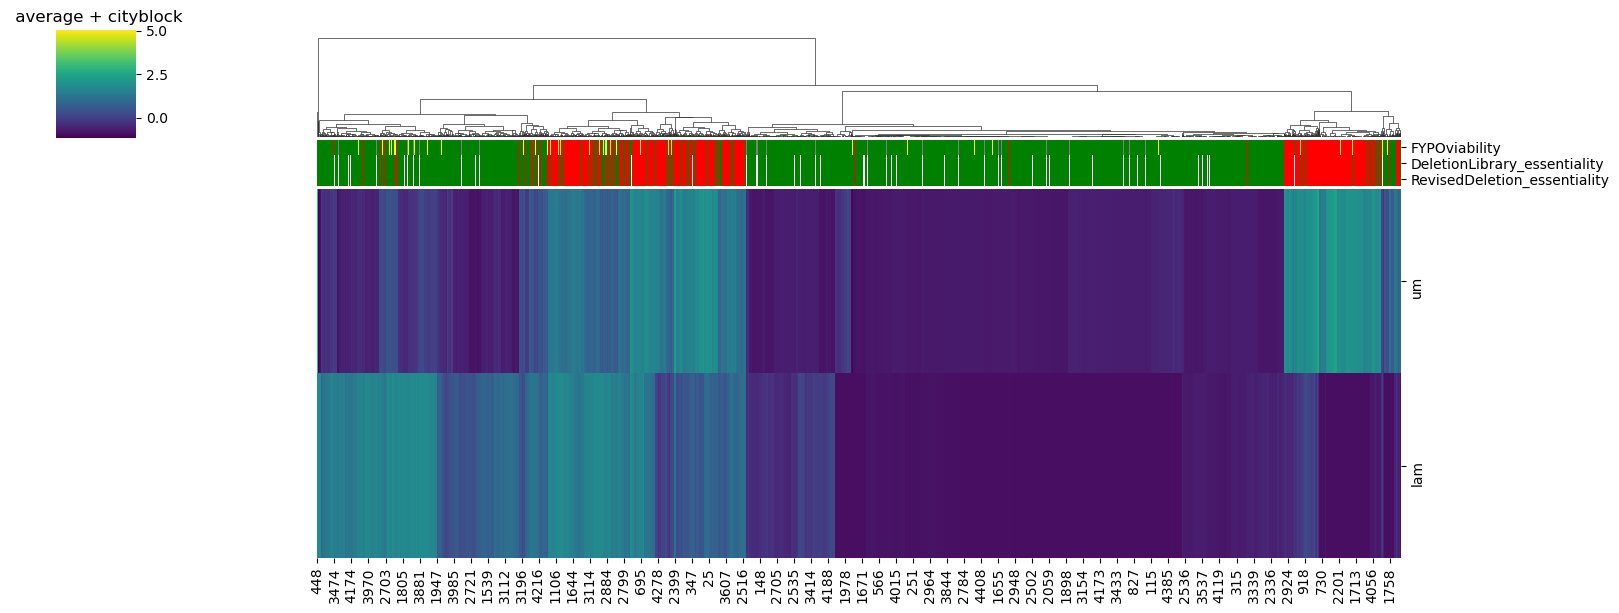

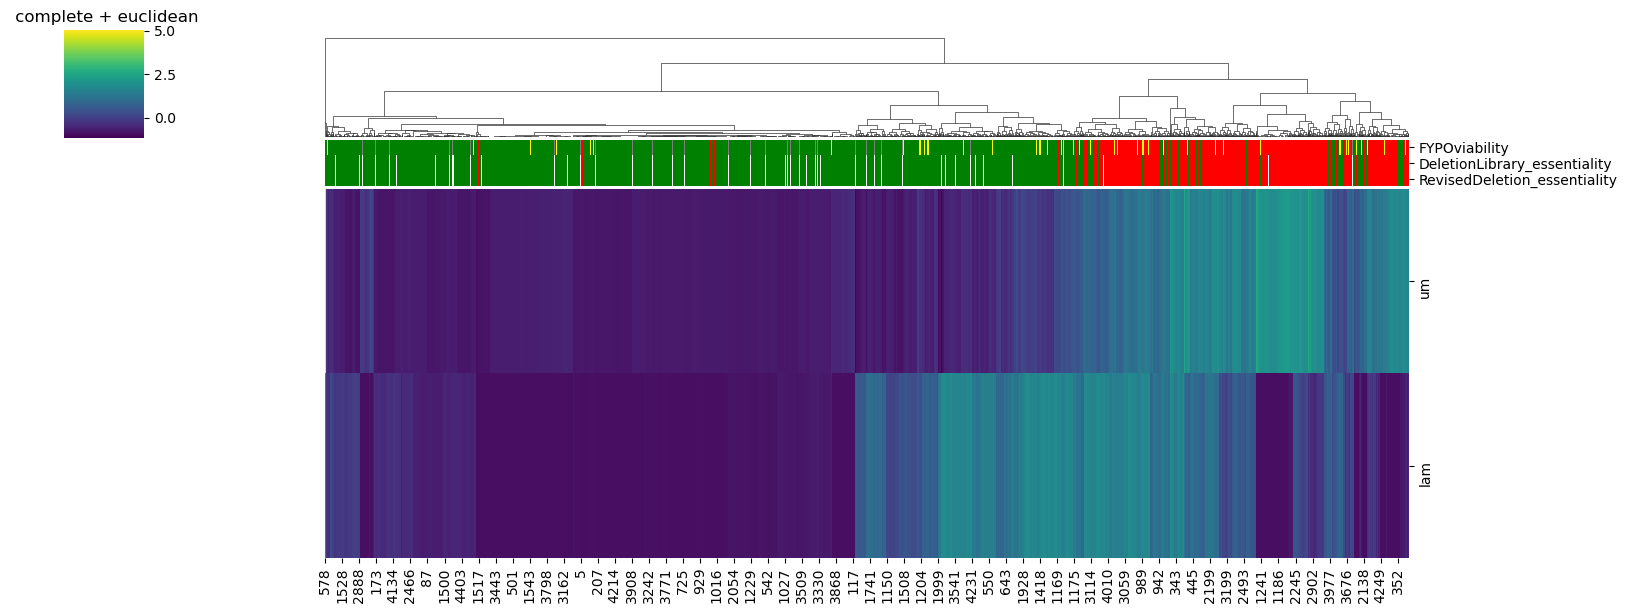

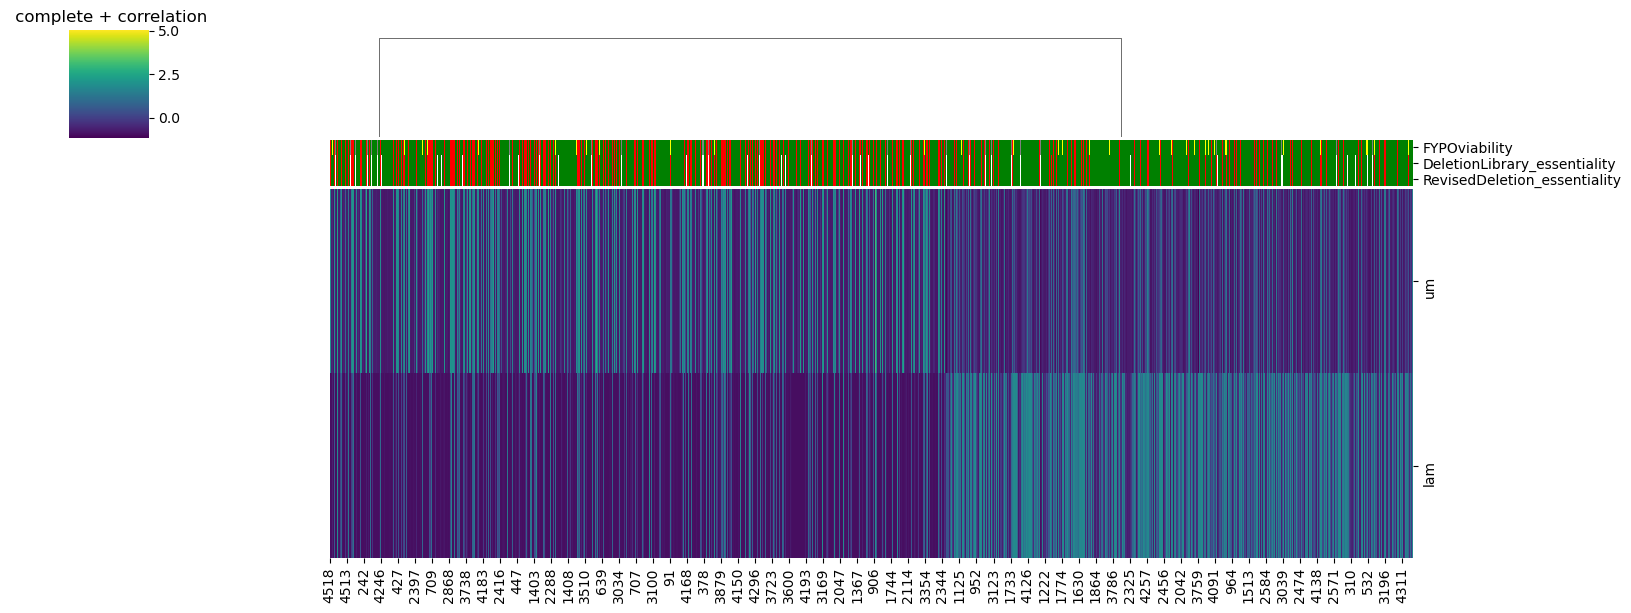

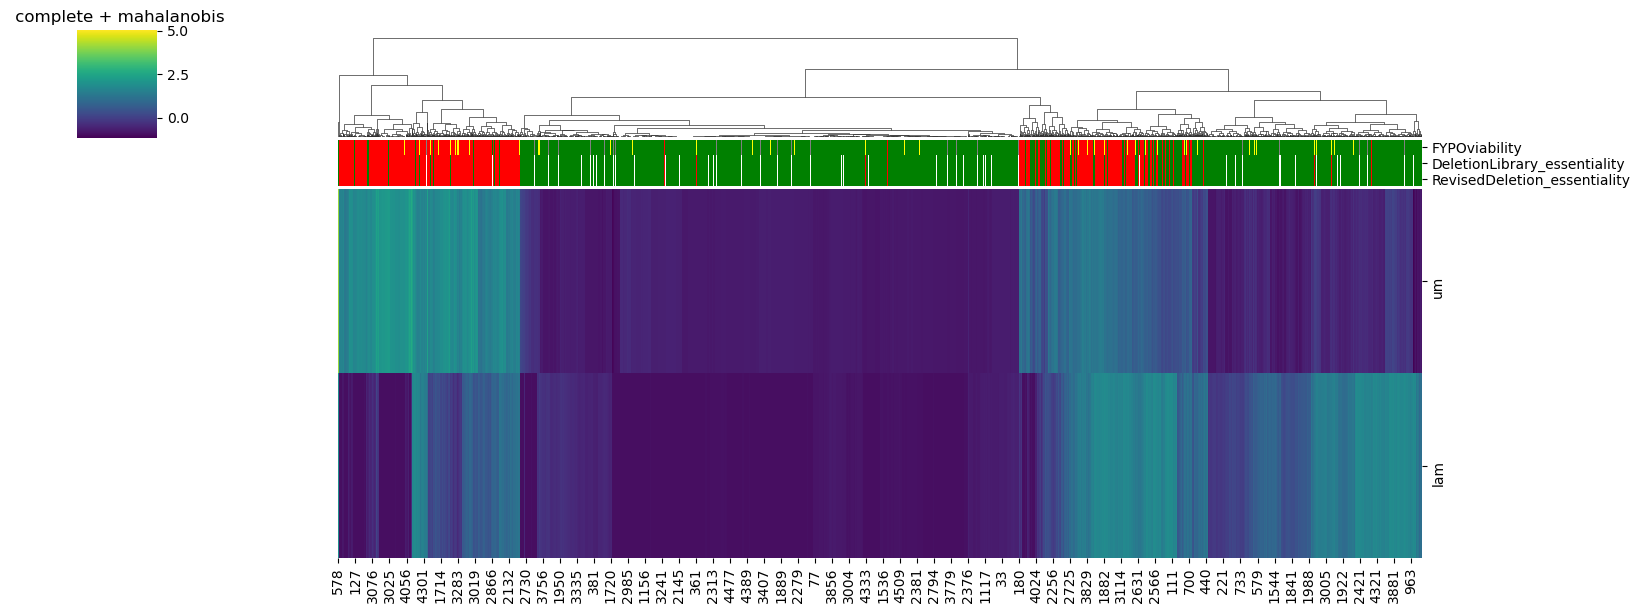

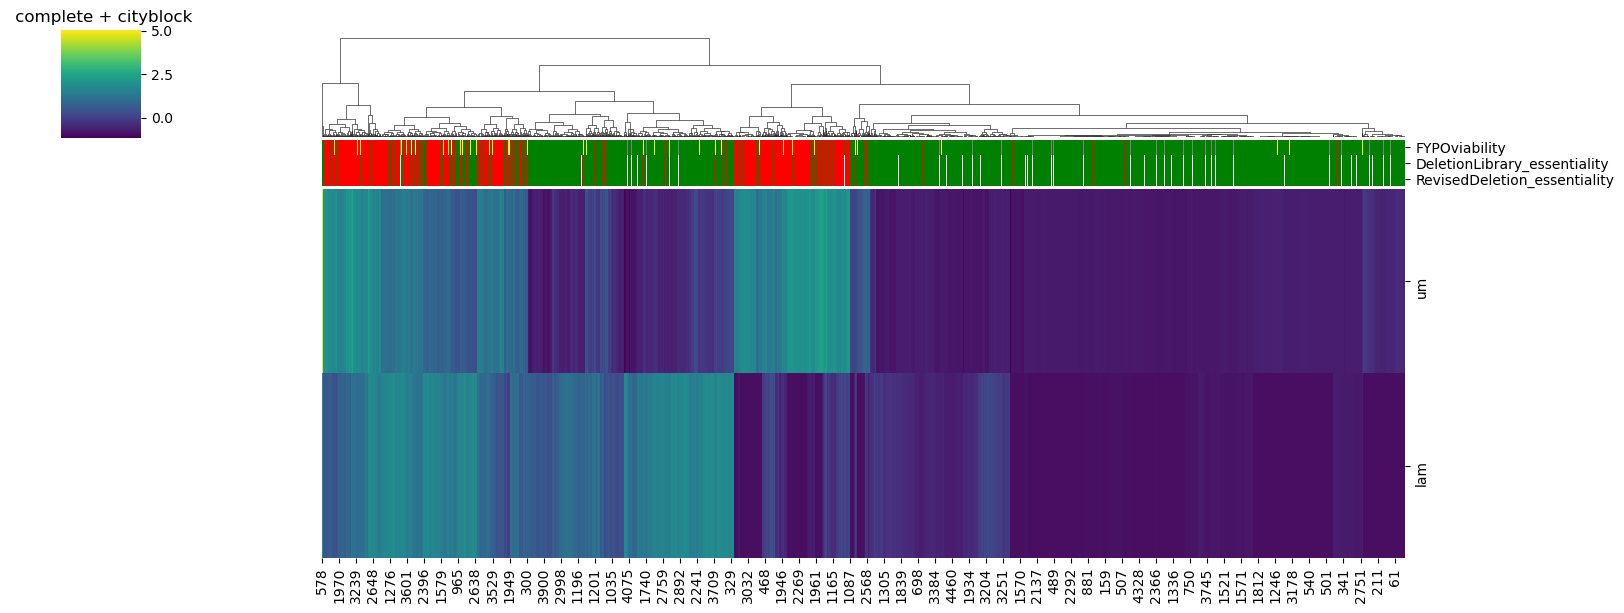

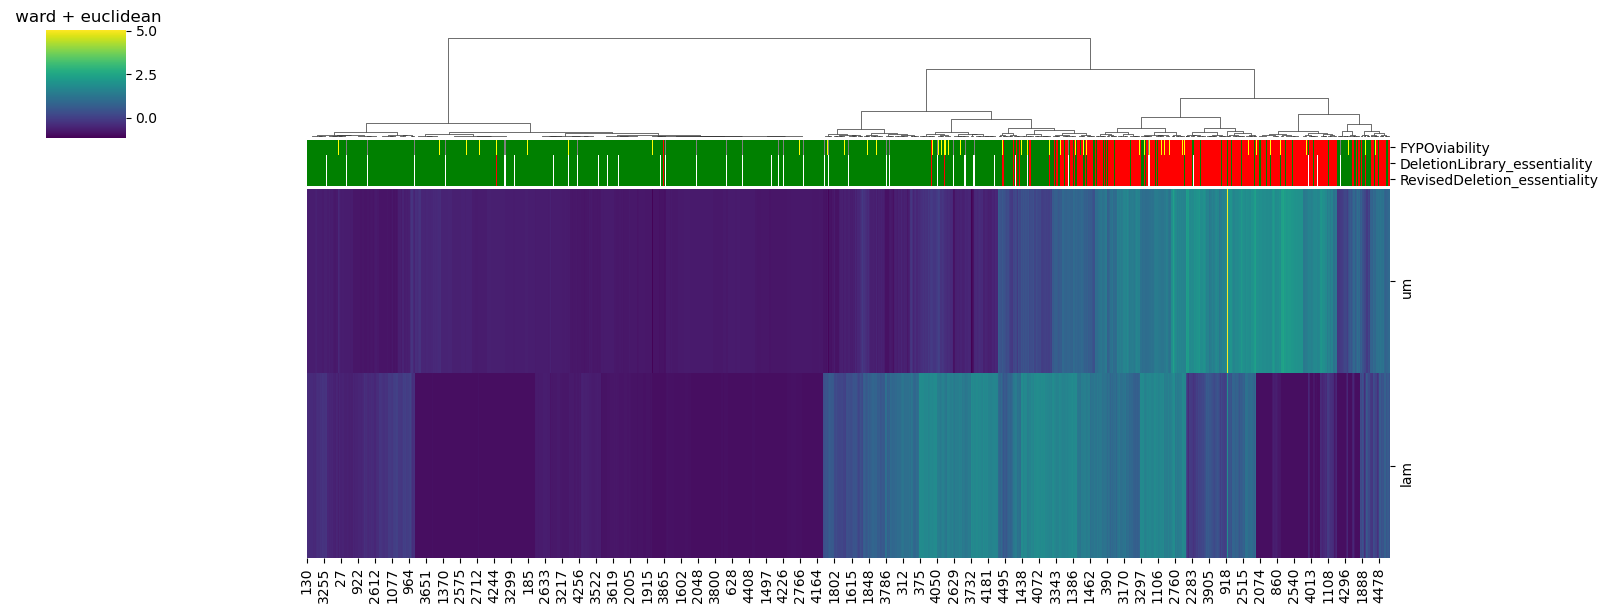

In [32]:
verified_essentiality = pd.read_excel("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/resources/verfication_results_summary.xlsx", index_col=0).dropna(subset=["Verified essentiality"])["Verified essentiality"].to_dict()

value_columns = ['um', 'lam']
df_success = df[df['Status'] == 'Success']

pt = PowerTransformer(method='yeo-johnson')
df_success["lam"] = pt.fit_transform(df_success["lam"].values.reshape(-1, 1)+1).flatten()
df_success.insert(3, "RevisedDeletion_essentiality", df_success["DeletionLibrary_essentiality"].map(lambda x: verified_essentiality[x] if x in verified_essentiality else x))
# df_success = df_success[value_columns]

# standard scale
scaler = StandardScaler()
df_success_scaled = pd.DataFrame(scaler.fit_transform(df_success[value_columns]), columns=df_success[value_columns].columns, index=df_success.index)

col_colors = df_success[['FYPOviability', 'DeletionLibrary_essentiality', 'RevisedDeletion_essentiality']]
col_colors['FYPOviability'] = col_colors['FYPOviability'].map({'viable': 'green', 'inviable': 'red', 'unknown': 'gray', 'condition-dependent': 'yellow'})
col_colors['DeletionLibrary_essentiality'] = col_colors['DeletionLibrary_essentiality'].map({'E': 'red', 'V': 'green', 'not_determined': 'gray'})
col_colors['RevisedDeletion_essentiality'] = col_colors['RevisedDeletion_essentiality'].map({'E': 'red', 'V': 'green', 'not_determined': 'gray'})

sns.clustermap(df_success_scaled.T, 
                            col_colors=col_colors,
                            col_cluster=True, 
                            row_cluster=False,
                            figsize=(16, 6),
                            method='average',
                            metric='euclidean',
                            cmap='viridis')

plt.title(" average + euclidean")
plt.show()
plt.close()

sns.clustermap(df_success_scaled.T, 
                            col_colors=col_colors,
                            col_cluster=True, 
                            row_cluster=False,
                            figsize=(16, 6),
                            method='average',
                            metric='mahalanobis',
                            cmap='viridis')
plt.title(" average + mahalanobis")
plt.show()
plt.close()

sns.clustermap(df_success_scaled.T, 
                            col_colors=col_colors,
                            col_cluster=True, 
                            row_cluster=False,
                            figsize=(16, 6),
                            method='average',
                            metric='correlation',
                            cmap='viridis')
plt.title(" average + correlation")
plt.show()
plt.close()

sns.clustermap(df_success_scaled.T, 
                            col_colors=col_colors,
                            col_cluster=True, 
                            row_cluster=False,
                            figsize=(16, 6),
                            method='average',
                            metric='cityblock',
                            cmap='viridis')
plt.title(" average + cityblock")
plt.show()
plt.close()

sns.clustermap(df_success_scaled.T, 
                            col_colors=col_colors,
                            col_cluster=True, 
                            row_cluster=False,
                            figsize=(16, 6),
                            method='complete',
                            metric='euclidean',
                            cmap='viridis')
plt.title(" complete + euclidean")
plt.show()
plt.close()

sns.clustermap(df_success_scaled.T, 
                            col_colors=col_colors,
                            col_cluster=True, 
                            row_cluster=False,
                            figsize=(16, 6),
                            method='complete',
                            metric='correlation',
                            cmap='viridis')
plt.title(" complete + correlation")
plt.show()
plt.close()

sns.clustermap(df_success_scaled.T, 
                            col_colors=col_colors,
                            col_cluster=True, 
                            row_cluster=False,
                            figsize=(16, 6),
                            method='complete',
                            metric='mahalanobis',
                            cmap='viridis')
plt.title(" complete + mahalanobis")
plt.show()
plt.close()

sns.clustermap(df_success_scaled.T, 
                            col_colors=col_colors,
                            col_cluster=True, 
                            row_cluster=False,
                            figsize=(16, 6),
                            method='complete',
                            metric='cityblock',
                            cmap='viridis')
plt.title(" complete + cityblock")
plt.show()
plt.close()

sns.clustermap(df_success_scaled.T, 
                            col_colors=col_colors,
                            col_cluster=True, 
                            row_cluster=False,
                            figsize=(16, 6),
                            method='ward',
                            metric='euclidean',
                            cmap='viridis')
plt.title(" ward + euclidean")
plt.show()
plt.close()



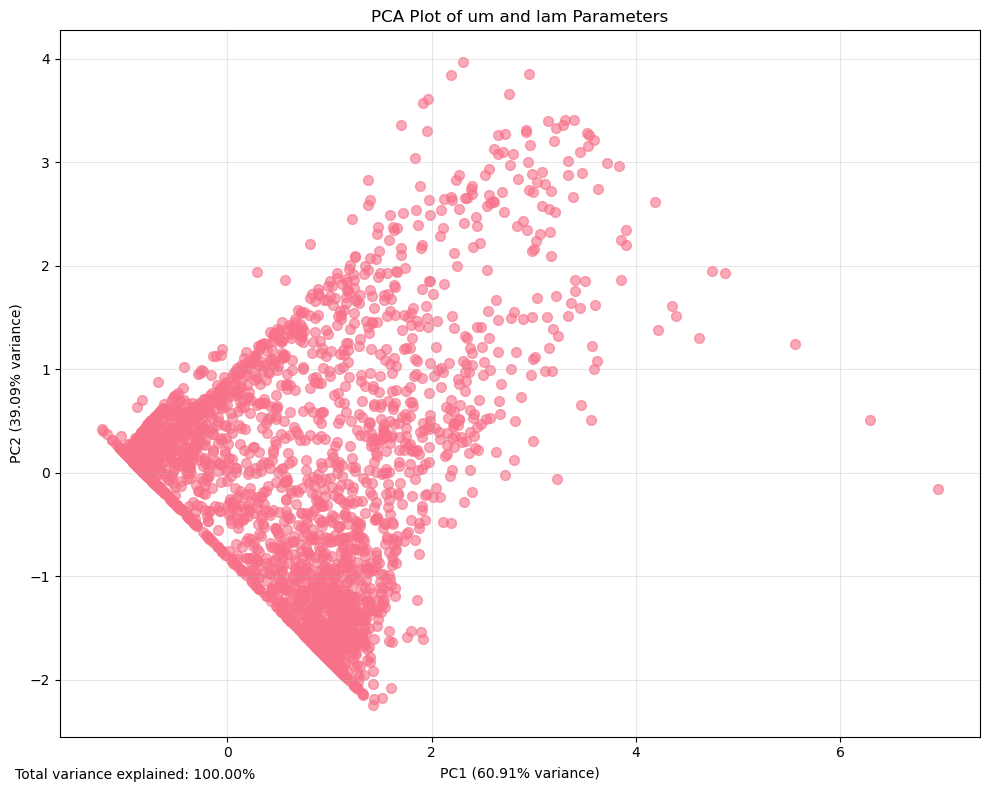

PCA Components:
PC1: um=0.707, lam=0.707
PC2: um=-0.707, lam=0.707
Explained variance ratio: PC1=0.609, PC2=0.391


In [33]:
# PCA plot based on um and lam parameters
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load data and filter for successful fits
raw_df = pd.read_csv(data_file, sep="\t")
df_success = raw_df[raw_df['Status'] == 'Success']

# Extract um and lam parameters
um_lam_data = df_success[['um', 'lam']].copy()

# Standardize the data
scaler = StandardScaler()
um_lam_scaled = scaler.fit_transform(um_lam_data)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(um_lam_scaled)

# Create PCA plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA Plot of um and lam Parameters')
plt.grid(True, alpha=0.3)

# Add explained variance information
total_variance = pca.explained_variance_ratio_.sum()
plt.figtext(0.02, 0.02, f'Total variance explained: {total_variance:.2%}', fontsize=10)

plt.tight_layout()
plt.show()

# Print PCA components
print("PCA Components:")
print(f"PC1: um={pca.components_[0][0]:.3f}, lam={pca.components_[0][1]:.3f}")
print(f"PC2: um={pca.components_[1][0]:.3f}, lam={pca.components_[1][1]:.3f}")
print(f"Explained variance ratio: PC1={pca.explained_variance_ratio_[0]:.3f}, PC2={pca.explained_variance_ratio_[1]:.3f}")


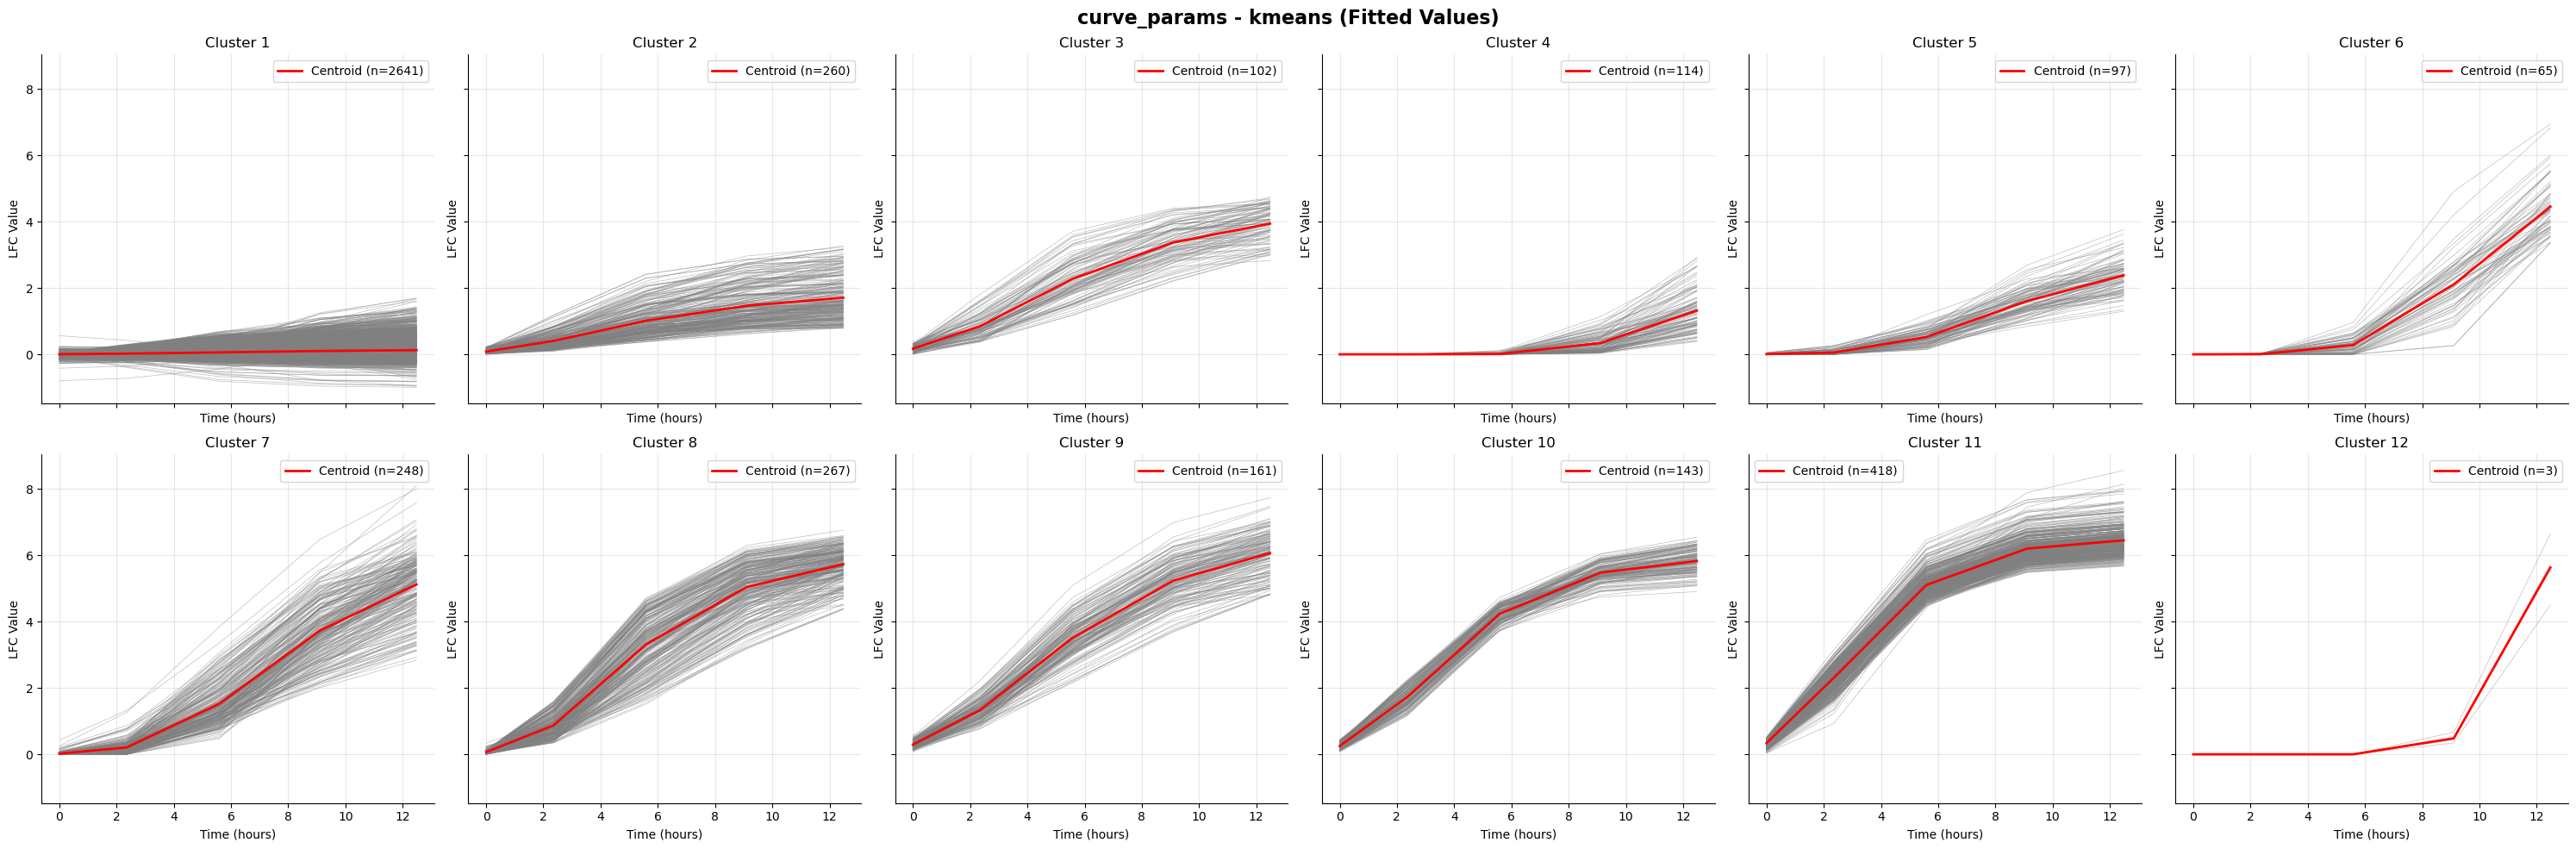

In [153]:
value_columns = ['A', 'um', 'lam']
raw_df = pd.read_csv(data_file, sep="\t")

df_success = raw_df[raw_df['Status'] == 'Success']

# standard scale
scaler = StandardScaler()
df_success_scaled = pd.DataFrame(scaler.fit_transform(df_success[value_columns]), columns=df_success[value_columns].columns, index=df_success.index)

col_colors = df_success[['FYPOviability', 'DeletionLibrary_essentiality']]
col_colors['FYPOviability'] = col_colors['FYPOviability'].map({'viable': 'green', 'inviable': 'red', 'unknown': 'gray', 'condition-dependent': 'yellow'})
col_colors['DeletionLibrary_essentiality'] = col_colors['DeletionLibrary_essentiality'].map({'E': 'red', 'V': 'green', 'not_determined': 'gray'})

kmeans = KMeans(n_clusters=36, random_state=42, tol=1e-3, max_iter=1000)
kmeans.fit(df_success_scaled)
labels = kmeans.labels_

rename_labels = {
    1: 1,
    5: 1,
    6: 1,
    13: 1,
    18: 1,
    26: 1,
    2: 1,
    10: 1,
    20: 1,
    3: 3,
    21: 3,
    28: 3,
    9: 9,
    16: 9,
    35: 9,
    25:25,
    29: 25,
    4: 4,
    8: 4,
    23: 4,
    27: 4,
    30: 4,
    7: 7,
    15: 7,
    0: 0,
    17: 0,
    11: 11,
    24: 11,
    32: 11,
    22: 33,
    33: 33,
    34: 33,
    14: 14,
    19: 14,
}

labels = np.array([rename_labels[label] if label in rename_labels else label for label in labels])

renamed_labels = {
    1: 1,
    33: 2,
    14: 3,
    9: 4,
    7: 5,
    25: 6,
    4: 7,
    11: 8,
    0: 9,
    31: 10,
    3: 11,
    12: 12
}

labels = np.array([renamed_labels[label] if label in renamed_labels else label for label in labels])


plot_depletion_curves(df_success, labels, "curve_params", "kmeans",row_num = 2, use_fitted=True)
plt.show()
plt.close()

In [ ]:
raw_df.sort_values(by=["cluster", "RevisedDeletion_essentiality", "um"], inplace=True)
raw_df.to_csv(output_folder/"manual_cluster_labels_based_on_kmeans36.tsv", sep="\t")

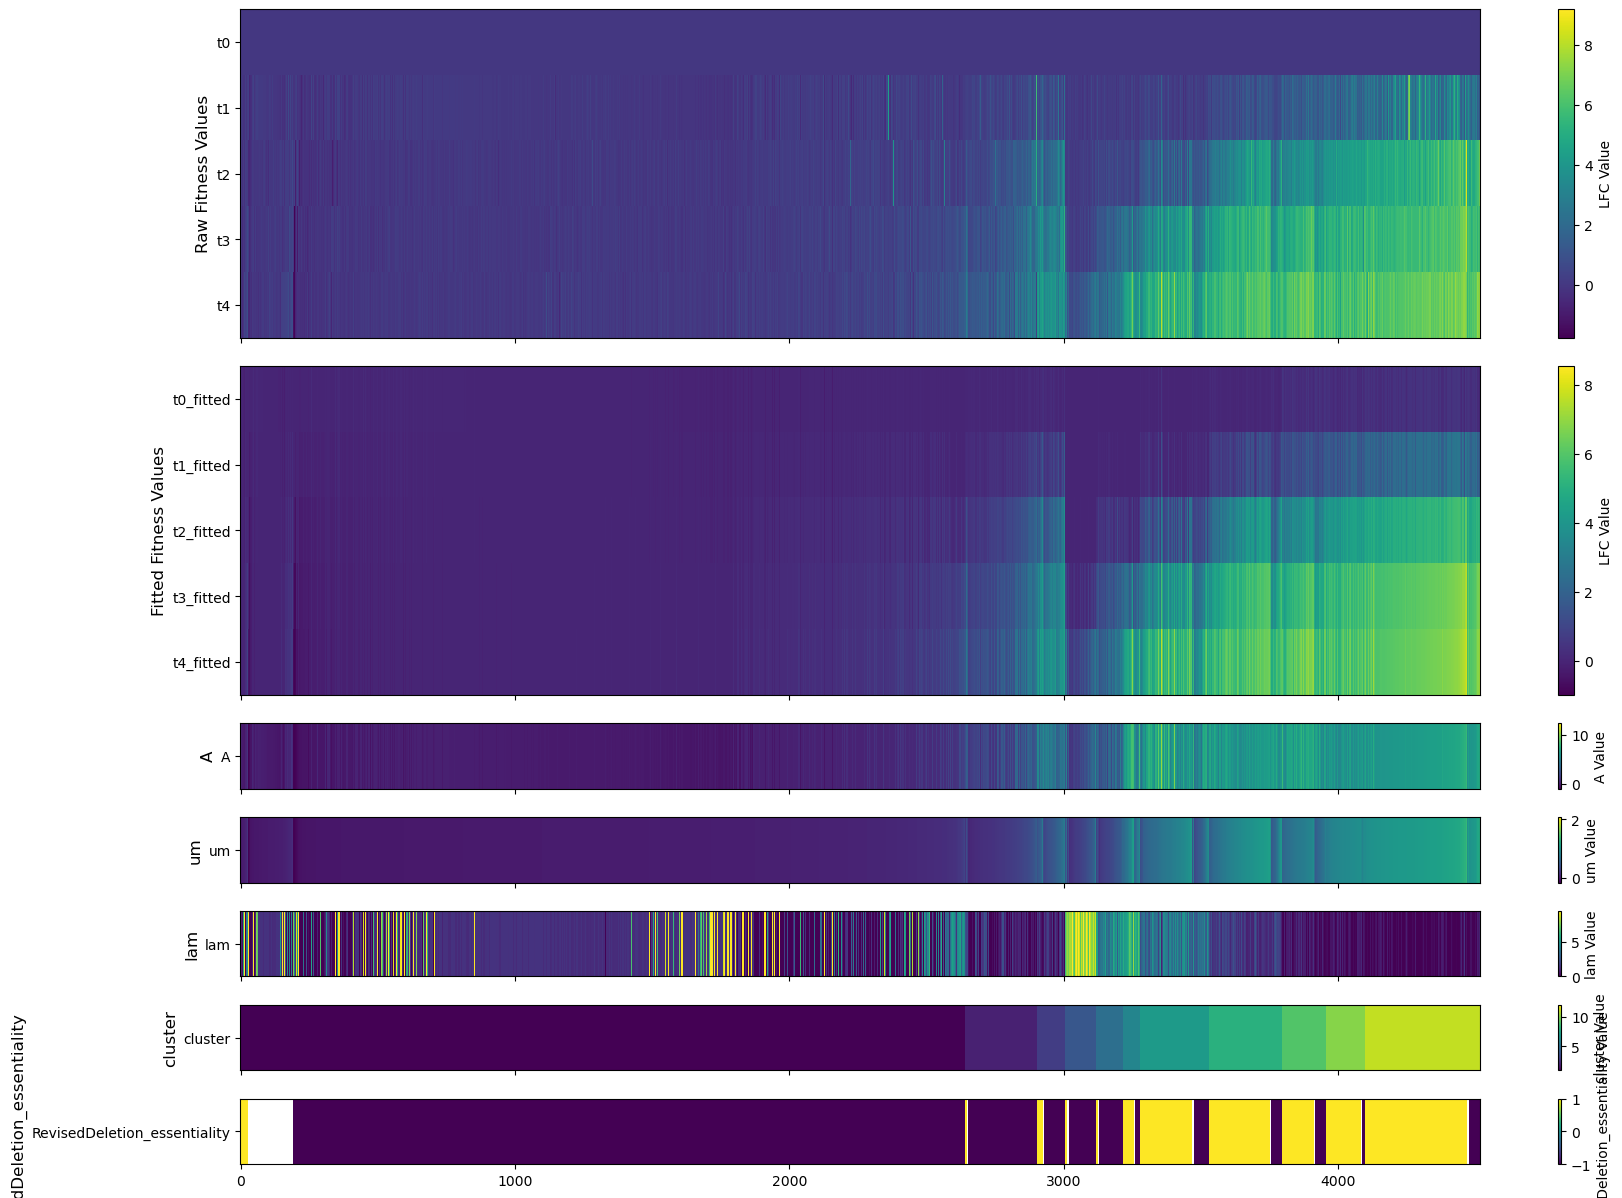

In [ ]:
col_colors = raw_df[['FYPOviability', 'DeletionLibrary_essentiality', "RevisedDeletion_essentiality"]]
col_colors['FYPOviability'] = col_colors['FYPOviability'].map({'viable': 'green', 'inviable': 'red', 'unknown': 'gray', 'condition-dependent': 'yellow'})
col_colors['DeletionLibrary_essentiality'] = col_colors['DeletionLibrary_essentiality'].map({'E': 'red', 'V': 'green', 'not_determined': 'gray'})
col_colors["RevisedDeletion_essentiality"] = col_colors["RevisedDeletion_essentiality"].map({'E': 1, 'V': -1, 'not_determined': 0})


fig, ax = plt.subplots(7,1, sharex=True, figsize=(20, 15), gridspec_kw={'height_ratios': [5, 5, 1, 1, 1, 1, 1]})

raw_values = raw_df[["t0", "t1", "t2", "t3", "t4"]].T.values
ax[0].imshow(raw_values, cmap="viridis", aspect="auto", interpolation='nearest')
ax[0].set_yticks(range(5))
ax[0].set_yticklabels(["t0", "t1", "t2", "t3", "t4"])
ax[0].set_ylabel("Raw Fitness Values", fontsize=12)
plt.colorbar(ax[0].imshow(raw_values, cmap="viridis", aspect="auto", interpolation='nearest'), ax=ax[0], label="LFC Value")

fitted_values = raw_df[["t0_fitted", "t1_fitted", "t2_fitted", "t3_fitted", "t4_fitted"]].T.values
ax[1].imshow(fitted_values, cmap="viridis", aspect="auto", interpolation='nearest')
ax[1].set_yticks(range(5))
ax[1].set_yticklabels(["t0_fitted", "t1_fitted", "t2_fitted", "t3_fitted", "t4_fitted"])
ax[1].set_ylabel("Fitted Fitness Values", fontsize=12)
plt.colorbar(ax[1].imshow(fitted_values, cmap="viridis", aspect="auto", interpolation='nearest'), ax=ax[1], label="LFC Value")

A_values = raw_df[["A"]].T.values
ax[2].imshow(A_values, cmap="viridis", aspect="auto", interpolation='nearest')
ax[2].set_yticks(range(1))
ax[2].set_yticklabels(["A"])
ax[2].set_ylabel("A", fontsize=12)
plt.colorbar(ax[2].imshow(A_values, cmap="viridis", aspect="auto", interpolation='nearest'), ax=ax[2], label="A Value")

um_values = raw_df[["um"]].T.values
ax[3].imshow(um_values, cmap="viridis", aspect="auto", interpolation='nearest')
ax[3].set_yticks(range(1))
ax[3].set_yticklabels(["um"])
ax[3].set_ylabel("um", fontsize=12)
plt.colorbar(ax[3].imshow(um_values, cmap="viridis", aspect="auto", interpolation='nearest'), ax=ax[3], label="um Value")

lam_values = raw_df[["lam"]].T.values
ax[4].imshow(lam_values, cmap="viridis", aspect="auto", interpolation='nearest')
ax[4].set_yticks(range(1))
ax[4].set_yticklabels(["lam"])
ax[4].set_ylabel("lam", fontsize=12)
plt.colorbar(ax[4].imshow(lam_values, cmap="viridis", aspect="auto", interpolation='nearest'), ax=ax[4], label="lam Value")

cluster_values = raw_df[["cluster"]].T.values
ax[5].imshow(cluster_values, cmap="viridis", aspect="auto", interpolation='nearest')
ax[5].set_yticks(range(1))
ax[5].set_yticklabels(["cluster"])
ax[5].set_ylabel("cluster", fontsize=12)
plt.colorbar(ax[5].imshow(cluster_values, cmap="viridis", aspect="auto", interpolation='nearest'), ax=ax[5], label="cluster Value")

revised_essentiality_values = col_colors[["RevisedDeletion_essentiality"]].T.values
ax[6].imshow(revised_essentiality_values, cmap="viridis", aspect="auto", interpolation='nearest')
ax[6].set_yticks(range(1))
ax[6].set_yticklabels(["RevisedDeletion_essentiality"])
ax[6].set_ylabel("RevisedDeletion_essentiality", fontsize=12)
plt.colorbar(ax[6].imshow(revised_essentiality_values, cmap="viridis", aspect="auto", interpolation='nearest'), ax=ax[6], label="Eessentiality")

plt.show()
plt.close()

In [ ]:
# Dimension reduction for visualizing cluster results
logger.info("Performing dimension reduction for cluster visualization")

# Prepare data for dimension reduction
X_for_reduction = df_success[["um", "lam"]].values  # Use the same data that was clustered
cluster_labels = df_success["cluster"].values

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_for_reduction)

# t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
X_tsne = tsne.fit_transform(X_for_reduction)

# UMAP (if available)
try:
    import umap
    umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    X_umap = umap_reducer.fit_transform(X_for_reduction)
    has_umap = True
except ImportError:
    logger.warning("UMAP not available, skipping UMAP visualization")
    has_umap = False

# Create visualization
n_plots = 3 if has_umap else 2
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
if n_plots == 1:
    axes = [axes]

# Color palette for clusters
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(cluster_labels))))

# PCA plot
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab20', alpha=0.7, s=20)
axes[0].set_title(f'PCA Visualization\n(Explained variance: {pca.explained_variance_ratio_.sum():.2%})', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0].grid(True, alpha=0.3)

# t-SNE plot
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab20', alpha=0.7, s=20)
axes[1].set_title('t-SNE Visualization', fontsize=12, fontweight='bold')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].grid(True, alpha=0.3)

# UMAP plot (if available)
if has_umap:
    scatter3 = axes[2].scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='tab20', alpha=0.7, s=20)
    axes[2].set_title('UMAP Visualization', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('UMAP 1')
    axes[2].set_ylabel('UMAP 2')
    axes[2].grid(True, alpha=0.3)

# Add colorbar
plt.colorbar(scatter1, ax=axes, label='Cluster', shrink=0.8)

plt.tight_layout()
plt.show()

# Create a more detailed PCA analysis
logger.info("Creating detailed PCA analysis")

# Fit PCA with more components to see variance explained
pca_full = PCA(random_state=42)
pca_full.fit(X_for_reduction)

# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Scree plot
ax1.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
         pca_full.explained_variance_ratio_, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Cumulative explained variance
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
ax2.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'ro-', linewidth=2, markersize=8)
ax2.axhline(y=0.8, color='k', linestyle='--', alpha=0.7, label='80% variance')
ax2.axhline(y=0.9, color='k', linestyle=':', alpha=0.7, label='90% variance')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance Ratio')
ax2.set_title('Cumulative Explained Variance', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

logger.info(f"First 2 PCs explain {pca.explained_variance_ratio_.sum():.2%} of variance")
logger.info(f"First 5 PCs explain {cumsum_var[4]:.2%} of variance")
logger.info(f"80% variance explained by {np.argmax(cumsum_var >= 0.8) + 1} components")
logger.info(f"90% variance explained by {np.argmax(cumsum_var >= 0.9) + 1} components")


2025-07-14 19:59:31,017 - INFO - Performing dimension reduction for cluster visualization


KeyError: 'cluster'